<h1>Content<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#IDEA-BEHIND" data-toc-modified-id="IDEA-BEHIND-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>IDEA BEHIND</a></span></li><li><span><a href="#STEP-1:-Check-each-data-source-separately" data-toc-modified-id="STEP-1:-Check-each-data-source-separately-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>STEP 1: Check each data source separately</a></span><ul class="toc-item"><li><span><a href="#Ideas-to-check" data-toc-modified-id="Ideas-to-check-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Ideas to check</a></span></li><li><span><a href="#Users" data-toc-modified-id="Users-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Users</a></span><ul class="toc-item"><li><span><a href="#Access" data-toc-modified-id="Access-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Access</a></span></li><li><span><a href="#Gender" data-toc-modified-id="Gender-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Gender</a></span></li><li><span><a href="#Country" data-toc-modified-id="Country-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Country</a></span></li><li><span><a href="#Age" data-toc-modified-id="Age-2.2.4"><span class="toc-item-num">2.2.4&nbsp;&nbsp;</span>Age</a></span></li><li><span><a href="#Age-and-gender" data-toc-modified-id="Age-and-gender-2.2.5"><span class="toc-item-num">2.2.5&nbsp;&nbsp;</span>Age and gender</a></span></li><li><span><a href="#Age-and-access-type" data-toc-modified-id="Age-and-access-type-2.2.6"><span class="toc-item-num">2.2.6&nbsp;&nbsp;</span>Age and access type</a></span></li><li><span><a href="#Age-and-country" data-toc-modified-id="Age-and-country-2.2.7"><span class="toc-item-num">2.2.7&nbsp;&nbsp;</span>Age and country</a></span></li></ul></li><li><span><a href="#Tracks" data-toc-modified-id="Tracks-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Tracks</a></span><ul class="toc-item"><li><span><a href="#Number-of-tracks-per-artist" data-toc-modified-id="Number-of-tracks-per-artist-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Number of tracks per artist</a></span></li><li><span><a href="#Number-of-albums-per-artist" data-toc-modified-id="Number-of-albums-per-artist-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Number of albums per artist</a></span></li><li><span><a href="#Number-of-tracks-per-album" data-toc-modified-id="Number-of-tracks-per-album-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>Number of tracks per album</a></span></li></ul></li><li><span><a href="#Allcountries" data-toc-modified-id="Allcountries-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Allcountries</a></span><ul class="toc-item"><li><span><a href="#Number-of-tracks-per-user" data-toc-modified-id="Number-of-tracks-per-user-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Number of tracks per user</a></span><ul class="toc-item"><li><span><a href="#Check-if-we-have-some-suspicious-outliers-(extreme-number-of-unique-tracks)" data-toc-modified-id="Check-if-we-have-some-suspicious-outliers-(extreme-number-of-unique-tracks)-2.4.1.1"><span class="toc-item-num">2.4.1.1&nbsp;&nbsp;</span>Check if we have some suspicious outliers (extreme number of unique tracks)</a></span></li><li><span><a href="#Check-how-many-users-with-tracks-more-than-3" data-toc-modified-id="Check-how-many-users-with-tracks-more-than-3-2.4.1.2"><span class="toc-item-num">2.4.1.2&nbsp;&nbsp;</span>Check how many users with tracks more than 3</a></span></li><li><span><a href="#Save-statistics" data-toc-modified-id="Save-statistics-2.4.1.3"><span class="toc-item-num">2.4.1.3&nbsp;&nbsp;</span>Save statistics</a></span></li></ul></li><li><span><a href="#Streams-by-OS" data-toc-modified-id="Streams-by-OS-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>Streams by OS</a></span></li><li><span><a href="#Users-by-OS" data-toc-modified-id="Users-by-OS-2.4.3"><span class="toc-item-num">2.4.3&nbsp;&nbsp;</span>Users by OS</a></span></li><li><span><a href="#Tracks-by-OS" data-toc-modified-id="Tracks-by-OS-2.4.4"><span class="toc-item-num">2.4.4&nbsp;&nbsp;</span>Tracks by OS</a></span></li><li><span><a href="#Distribution-of-streams-per-user" data-toc-modified-id="Distribution-of-streams-per-user-2.4.5"><span class="toc-item-num">2.4.5&nbsp;&nbsp;</span>Distribution of streams per user</a></span><ul class="toc-item"><li><span><a href="#Check-if-we-have-some-suspicious-outliers-(extreme-number-of-streams)" data-toc-modified-id="Check-if-we-have-some-suspicious-outliers-(extreme-number-of-streams)-2.4.5.1"><span class="toc-item-num">2.4.5.1&nbsp;&nbsp;</span>Check if we have some suspicious outliers (extreme number of streams)</a></span></li><li><span><a href="#Check-how-many-users-with-streams-more-than-4" data-toc-modified-id="Check-how-many-users-with-streams-more-than-4-2.4.5.2"><span class="toc-item-num">2.4.5.2&nbsp;&nbsp;</span>Check how many users with streams more than 4</a></span></li><li><span><a href="#Save-statistics-for-further-analysis" data-toc-modified-id="Save-statistics-for-further-analysis-2.4.5.3"><span class="toc-item-num">2.4.5.3&nbsp;&nbsp;</span>Save statistics for further analysis</a></span></li></ul></li><li><span><a href="#Distribution-of-stream-length" data-toc-modified-id="Distribution-of-stream-length-2.4.6"><span class="toc-item-num">2.4.6&nbsp;&nbsp;</span>Distribution of stream length</a></span><ul class="toc-item"><li><span><a href="#Check-if-we-have-some-suspicious-outliers-(extreme-length-of-streams)" data-toc-modified-id="Check-if-we-have-some-suspicious-outliers-(extreme-length-of-streams)-2.4.6.1"><span class="toc-item-num">2.4.6.1&nbsp;&nbsp;</span>Check if we have some suspicious outliers (extreme length of streams)</a></span></li><li><span><a href="#Check-how-many-users-have-length-of-streams-more-than-300" data-toc-modified-id="Check-how-many-users-have-length-of-streams-more-than-300-2.4.6.2"><span class="toc-item-num">2.4.6.2&nbsp;&nbsp;</span>Check how many users have length of streams more than 300</a></span></li><li><span><a href="#Save-statistics" data-toc-modified-id="Save-statistics-2.4.6.3"><span class="toc-item-num">2.4.6.3&nbsp;&nbsp;</span>Save statistics</a></span></li></ul></li><li><span><a href="#DIstribution-of-number-of-devices-per-user" data-toc-modified-id="DIstribution-of-number-of-devices-per-user-2.4.7"><span class="toc-item-num">2.4.7&nbsp;&nbsp;</span>DIstribution of number of devices per user</a></span></li><li><span><a href="#Distribution-of-track-length-for-different-OS" data-toc-modified-id="Distribution-of-track-length-for-different-OS-2.4.8"><span class="toc-item-num">2.4.8&nbsp;&nbsp;</span>Distribution of track length for different OS</a></span></li><li><span><a href="#Distribution-of-track-length-for-different-device-types" data-toc-modified-id="Distribution-of-track-length-for-different-device-types-2.4.9"><span class="toc-item-num">2.4.9&nbsp;&nbsp;</span>Distribution of track length for different device types</a></span></li><li><span><a href="#Distribution-of-gap-between-streams-for-users" data-toc-modified-id="Distribution-of-gap-between-streams-for-users-2.4.10"><span class="toc-item-num">2.4.10&nbsp;&nbsp;</span>Distribution of gap between streams for users</a></span><ul class="toc-item"><li><span><a href="#Check-for-users-who-have-0-median-gap-between-streams" data-toc-modified-id="Check-for-users-who-have-0-median-gap-between-streams-2.4.10.1"><span class="toc-item-num">2.4.10.1&nbsp;&nbsp;</span>Check for users who have 0 median gap between streams</a></span></li><li><span><a href="#Save-statistics" data-toc-modified-id="Save-statistics-2.4.10.2"><span class="toc-item-num">2.4.10.2&nbsp;&nbsp;</span>Save statistics</a></span></li></ul></li><li><span><a href="#Dependency-between-stream-length-and-gap-between-streams" data-toc-modified-id="Dependency-between-stream-length-and-gap-between-streams-2.4.11"><span class="toc-item-num">2.4.11&nbsp;&nbsp;</span>Dependency between stream length and gap between streams</a></span></li><li><span><a href="#Dependency-between-stream-length-and-number-of-streams" data-toc-modified-id="Dependency-between-stream-length-and-number-of-streams-2.4.12"><span class="toc-item-num">2.4.12&nbsp;&nbsp;</span>Dependency between stream length and number of streams</a></span></li></ul></li><li><span><a href="#Fast-check-if-users-with-huge-number-of-streams-are-the-same-as-users-with-small-gap-between-streams-and-huge-length-of-streams" data-toc-modified-id="Fast-check-if-users-with-huge-number-of-streams-are-the-same-as-users-with-small-gap-between-streams-and-huge-length-of-streams-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Fast check if users with huge number of streams are the same as users with small gap between streams and huge length of streams</a></span></li><li><span><a href="#Calculate-statistics-for-users-to-train-One-class-classifier-to-find-outliers" data-toc-modified-id="Calculate-statistics-for-users-to-train-One-class-classifier-to-find-outliers-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Calculate statistics for users to train One-class classifier to find outliers</a></span><ul class="toc-item"><li><span><a href="#Generate-statistics-for-users" data-toc-modified-id="Generate-statistics-for-users-2.6.1"><span class="toc-item-num">2.6.1&nbsp;&nbsp;</span>Generate statistics for users</a></span><ul class="toc-item"><li><span><a href="#It-is-important-that-outliers-have-suspicious-number-of-tracks" data-toc-modified-id="It-is-important-that-outliers-have-suspicious-number-of-tracks-2.6.1.1"><span class="toc-item-num">2.6.1.1&nbsp;&nbsp;</span>It is important that outliers have suspicious number of tracks</a></span></li><li><span><a href="#possible-number-of-outliers-at-step-1" data-toc-modified-id="possible-number-of-outliers-at-step-1-2.6.1.2"><span class="toc-item-num">2.6.1.2&nbsp;&nbsp;</span>possible number of outliers at step 1</a></span></li></ul></li></ul></li><li><span><a href="#Step-1-conclusions:" data-toc-modified-id="Step-1-conclusions:-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Step 1 conclusions:</a></span></li></ul></li><li><span><a href="#STEP-2:-Track-history" data-toc-modified-id="STEP-2:-Track-history-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>STEP 2: Track history</a></span><ul class="toc-item"><li><span><a href="#Check-if-suspicious-users-have-similar-track-history" data-toc-modified-id="Check-if-suspicious-users-have-similar-track-history-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Check if suspicious users have similar track history</a></span></li><li><span><a href="#Fraudsters-could-try-to-promote-rare-tracks-that-have-little-number-of-streams-by-other-users" data-toc-modified-id="Fraudsters-could-try-to-promote-rare-tracks-that-have-little-number-of-streams-by-other-users-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Fraudsters could try to promote rare tracks that have little number of streams by other users</a></span><ul class="toc-item"><li><span><a href="#Users-tend-to-listen-different-tracks-but-some-of-them-listen-only-few" data-toc-modified-id="Users-tend-to-listen-different-tracks-but-some-of-them-listen-only-few-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Users tend to listen different tracks but some of them listen only few</a></span></li></ul></li><li><span><a href="#For-each-user-we-receive-track-embeddings" data-toc-modified-id="For-each-user-we-receive-track-embeddings-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>For each user we receive track embeddings</a></span><ul class="toc-item"><li><span><a href="#Deep-learning-for-user-emdeddings" data-toc-modified-id="Deep-learning-for-user-emdeddings-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Deep learning for user emdeddings</a></span></li></ul></li><li><span><a href="#Print-all-users-in-2d-space" data-toc-modified-id="Print-all-users-in-2d-space-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Print all users in 2d space</a></span></li><li><span><a href="#Similar-users" data-toc-modified-id="Similar-users-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Similar users</a></span><ul class="toc-item"><li><span><a href="#Based-on-deep-learning-embeddings" data-toc-modified-id="Based-on-deep-learning-embeddings-3.5.1"><span class="toc-item-num">3.5.1&nbsp;&nbsp;</span>Based on deep learning embeddings</a></span></li><li><span><a href="#TF-IDF" data-toc-modified-id="TF-IDF-3.5.2"><span class="toc-item-num">3.5.2&nbsp;&nbsp;</span>TF-IDF</a></span></li></ul></li><li><span><a href="#Graph-of-users-with-possible-multiple-accounts" data-toc-modified-id="Graph-of-users-with-possible-multiple-accounts-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Graph of users with possible multiple accounts</a></span></li><li><span><a href="#Step-2-conclusions:" data-toc-modified-id="Step-2-conclusions:-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Step 2 conclusions:</a></span></li></ul></li><li><span><a href="#Some-other-info-about-Type-II-fraudsters" data-toc-modified-id="Some-other-info-about-Type-II-fraudsters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Some other info about Type II fraudsters</a></span><ul class="toc-item"><li><span><a href="#By-countries" data-toc-modified-id="By-countries-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>By countries</a></span></li><li><span><a href="#By-access-type" data-toc-modified-id="By-access-type-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>By access type</a></span></li><li><span><a href="#By-age" data-toc-modified-id="By-age-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>By age</a></span></li><li><span><a href="#By-OS" data-toc-modified-id="By-OS-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>By OS</a></span></li><li><span><a href="#By-device-type" data-toc-modified-id="By-device-type-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>By device type</a></span></li></ul></li><li><span><a href="#STEP-4:-FRAUD-MODEL" data-toc-modified-id="STEP-4:-FRAUD-MODEL-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>STEP 4: FRAUD MODEL</a></span></li></ul></div>

# IDEA BEHIND

Hypothesis: 

Fraudulent user is a user who streams a lot of different tracks or one track with high frequency and possibly using multiple accounts.


In this EDA notebook I will try to find suspicious user behaviour and determine close to each other accounts by analyzing tracks history

# STEP 1: Check each data source separately

## Ideas to check

<div class="alert alert-block alert-warning">
<ul><b>
    <li style="font-size:20px">fraudulent users have lots of streams</li>
    <li style="font-size:20px">fraudulent users have lots of tracks</li>
    <li style="font-size:20px">fraudulent users have close to 0 gap between streams</li>
    <li style="font-size:20px">fraudulent users have long streams</li>
    </b>
</ul>
</div>

## Users

In [1]:
from libs.useful_functions import *

D:\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
D:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
plt.rcParams.update({'figure.figsize' : (10, 8)})

In [3]:
path = r'D:/Projects/data/'
# path = r''

users = pd.read_csv(path + 'users', compression = 'gzip', header = None)
users.columns = ['access', 'birth_year', 'country', 'gender', 'user_id']
users['user_id'] = users['user_id'].map(lambda x: x.split(':')[1].replace("{", "").replace("}", "").strip('"'))
users.head()

,access,birth_year,country,gender,user_id
0,"{""access"":""free""","birth_year:""1989""",country:8,"gender:""female""",093449f2282b4e4793948bbc3e9f1fd7278c0c49
1,"{""access"":""premium""","birth_year:""2001""",country:4,"gender:""female""",3e9603e5ab69c5cfe14dcc1954c46cd849940b24
2,"{""access"":""premium""","birth_year:""1988""",country:52,"gender:""female""",c12f6f2784787619d91f61cf215480b70d47f36e
3,"{""access"":""premium""","birth_year:""1995""",country:16,"gender:""female""",d55e6dc8e7fdd87d42b639ed27ca95795738308b
4,"{""access"":""premium""","birth_year:""1996""",country:44,"gender:""female""",6b1867e55d95cd39f0b3eac38518fd11572e732f


In [4]:
print("Data shape:")
users.shape

Data shape:


(1787756, 5)

In [5]:
print("One row per user:")
users.shape[0] == users['user_id'].nunique()

One row per user:


True

In [6]:
print("Unique values:")
users.nunique()

Unique values:


access              3
birth_year        146
country            61
gender              3
user_id       1787756
dtype: int64

### Access

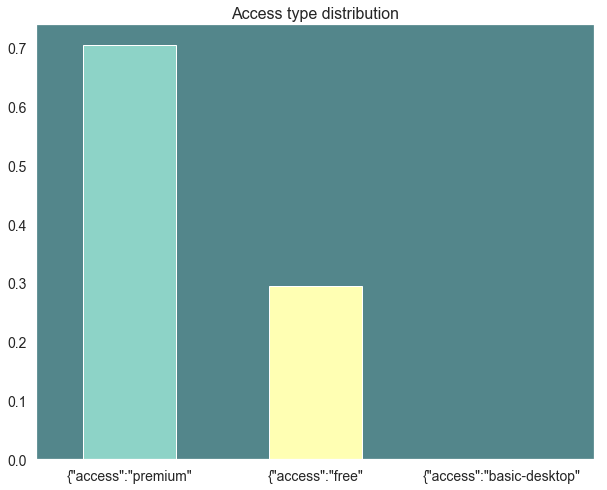

In [7]:
plt.title('Access type distribution')
(users['access'].value_counts() / users.shape[0]).plot(kind = 'bar')
plt.xticks(rotation = 0)
plt.show()

### Gender

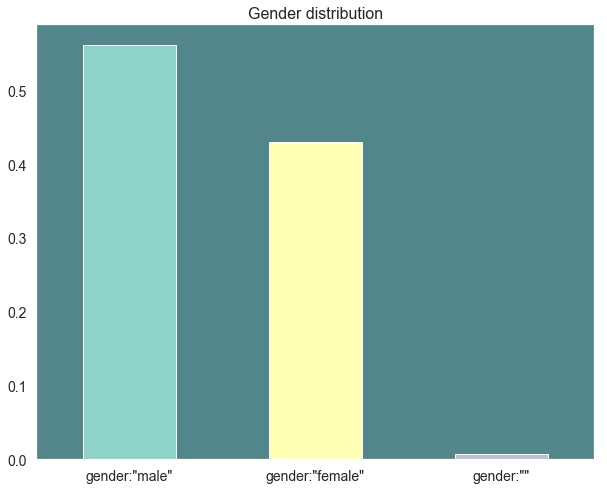

In [8]:
plt.title('Gender distribution')
(users['gender'].value_counts() / users.shape[0]).plot(kind = 'bar')
plt.xticks(rotation = 0)
plt.show()

### Country

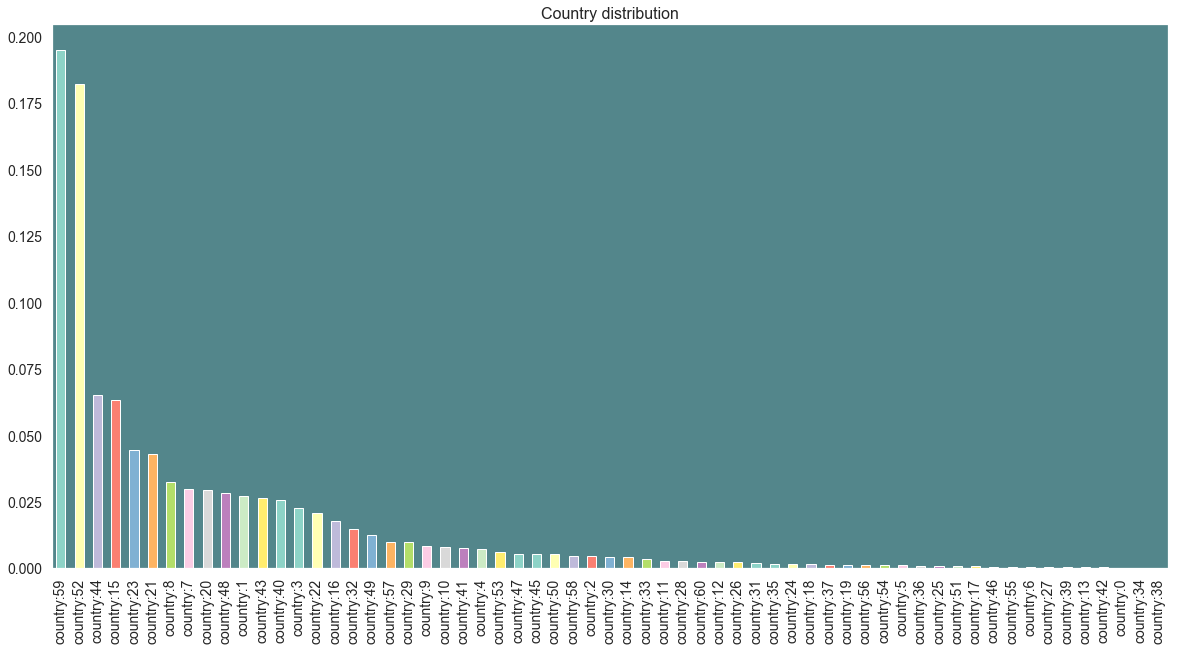

In [9]:
plt.title('Country distribution')
(users['country'].value_counts() / users.shape[0]).plot(kind = 'bar', figsize  = (20, 10))
plt.xticks(rotation = 90)
plt.show()

In [10]:
print("Top 4 countries make around {0:0.1f}% of traffic".format(100*users[users['country'].isin(users['country'].value_counts().index[:4])].shape[0] / users.shape[0], ))
print('Countries: ', users['country'].value_counts().index[:4].tolist())

Top 4 countries make around 50.5% of traffic
Countries:  ['country:59', 'country:52', 'country:44', 'country:15']


In [11]:
top_countries = users['country'].value_counts().index[:4].tolist()

### Age

In [12]:
users['birth_year'] = users['birth_year'].map(lambda x: clean_text(x , 'numbers')).replace('', '2000').astype(int)

In [13]:
users['age'] = 2018 - users['birth_year']

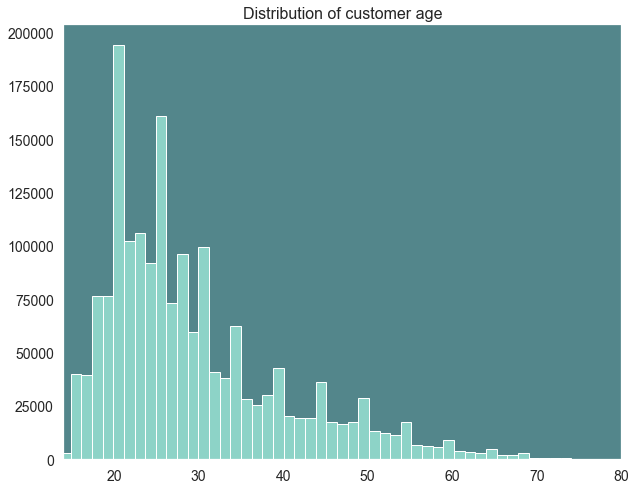

In [14]:
plt.title('Distribution of customer age')
ax = users['age'].hist(bins = 100)
ax.set_xlim(14, 80)
plt.show()

### Age and gender

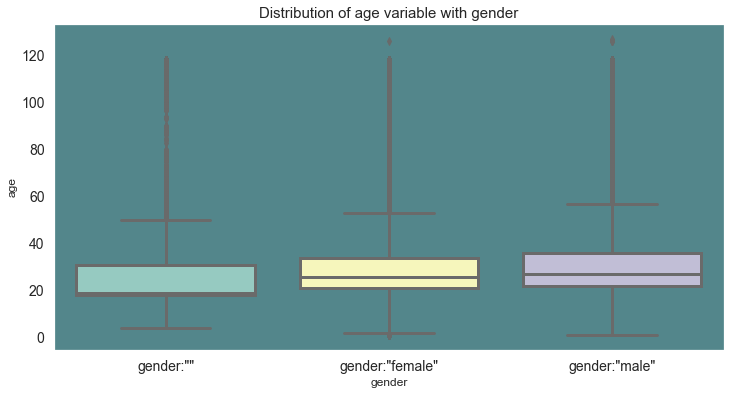

In [15]:
x_name = 'gender'
y_name = 'age'
col_order = np.sort(users[x_name].unique()).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=x_name, y=y_name, data=users, order=col_order)
plt.xlabel(x_name, fontsize=12)
plt.ylabel(y_name, fontsize=12)
plt.title("Distribution of %s variable with %s" % (y_name, x_name), fontsize=15)
plt.show()

### Age and access type

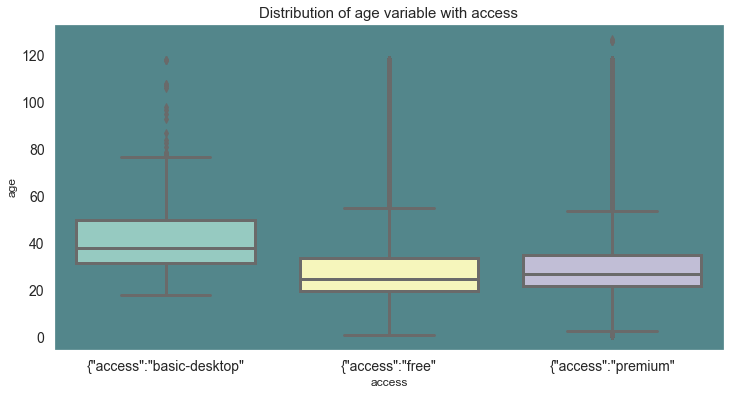

In [16]:
x_name = 'access'
y_name = 'age'
col_order = np.sort(users[x_name].unique()).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=x_name, y=y_name, data=users, order=col_order)
plt.xlabel(x_name, fontsize=12)
plt.ylabel(y_name, fontsize=12)
plt.title("Distribution of %s variable with %s" % (y_name, x_name), fontsize=15)
plt.show()

### Age and country

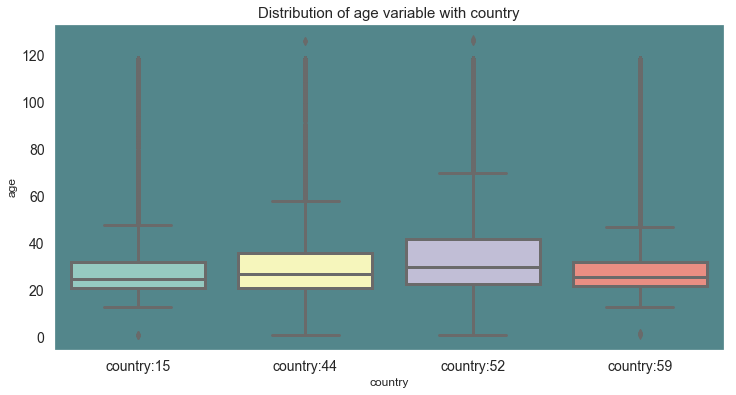

In [17]:
x_name = 'country'
y_name = 'age'
col_order = np.sort(top_countries).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=x_name, y=y_name, data=users[users['country'].isin(top_countries)], order=col_order)
plt.xlabel(x_name, fontsize=12)
plt.ylabel(y_name, fontsize=12)
plt.title("Distribution of %s variable with %s" % (y_name, x_name), fontsize=15)
plt.show()

## Tracks

In [18]:
tracks=gzip.open(path + 'tracks','rb')
tracks=tracks.read().decode().split('\n')

strings = []

counter = 0
for track in tracks:    
    line = json.loads(track)
    _ = []
    for key, value in line.items():
        _.append(key  + ' : ' + value)
    strings.append(_)

tracks = pd.DataFrame(strings)

In [19]:
# tracks = pd.read_csv(path + 'tracks', compression = 'gzip', quotechar = '"',
#                      header = None, error_bad_lines=False)
tracks.columns = ['album_artist', 'album_code', 'album_name', 'track_id', 'track_name']
tracks['track_id'] = tracks['track_id'].map(lambda x: x.split(':')[1].replace("{", "").replace("}", "").strip('"'))
tracks.head()

,album_artist,album_code,album_name,track_id,track_name
0,album_artist : Tasia Rojas,album_code : ece406c1937c4123e6b935f39898770dc...,album_name : Salmon Addition,fe2f34b55827b9721aa503d1dc9f3bca951859de,track_name : Doubtful Anteater
1,album_artist : Gertrude Faulkner,album_code : bb94c41eade59eeec79b04aa141c99344...,album_name : Newfoundland Quilt,2432c3346fc867e9026174ea73ab787a7fdeaa1f,track_name : Heartbreaking Louse
2,album_artist : Ora Corcoran,album_code : 0db473f623b01b0134f8178512f91e5ac...,album_name : Havanese Push,cb5e2409dfa5c9c8ccabdca2afeb6e84eca9a435,track_name : Watery Tortoise
3,album_artist : Shanika Wing,album_code : 4aadb443b1d8cc4c84a6ca1dd348c5993...,album_name : Puma Hate,2998e8ecabbf9d220dc22c516740f7982b2353e8,track_name : Nutritious Ox
4,album_artist : Lonnie Hope,album_code : a2b64056f39d60b0de18550d43a37b64b...,album_name : Kingfisher Garden,fb581ad122d260941757c5a2b1ed1a42108d632f,track_name : Foregoing Umbrellabird


In [20]:
print("Data shape:")
tracks.shape

Data shape:


(83426, 5)

In [21]:
print("One row per user:")
tracks.shape[0] == tracks['track_id'].nunique()

One row per user:


True

In [22]:
print("Unique values:")
tracks.nunique()

Unique values:


album_artist    16915
album_code      24913
album_name      23201
track_id        83426
track_name      70979
dtype: int64

### Number of tracks per artist

Median value: 2.0


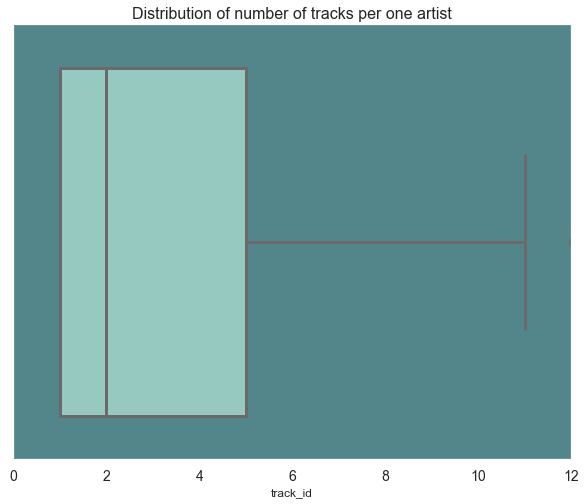

In [23]:
plt.title('Distribution of number of tracks per one artist')
print("Median value: %s" % tracks.groupby('album_artist')['track_id'].nunique().median())
ax = sns.boxplot(x=tracks.groupby('album_artist')['track_id'].nunique())
ax.set_xlim(0, 12)
plt.show()

### Number of albums per artist

Median value: 1.0


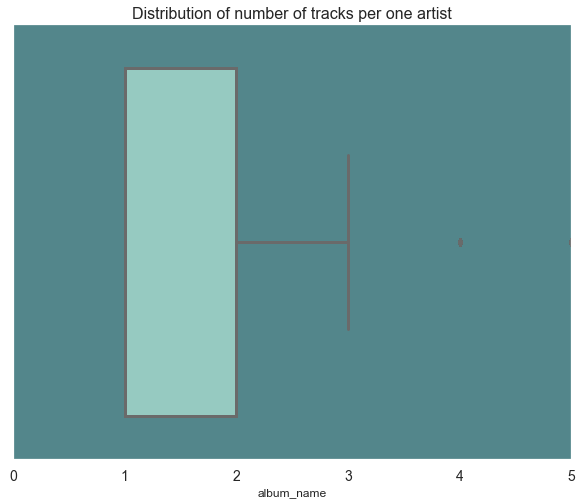

In [24]:
plt.title('Distribution of number of tracks per one artist')
print("Median value: %s" % tracks.groupby('album_artist')['album_name'].nunique().median())
ax = sns.boxplot(x=tracks.groupby('album_artist')['album_name'].nunique())
ax.set_xlim(0, 5)
plt.show()

### Number of tracks per album

Median value: 1.0


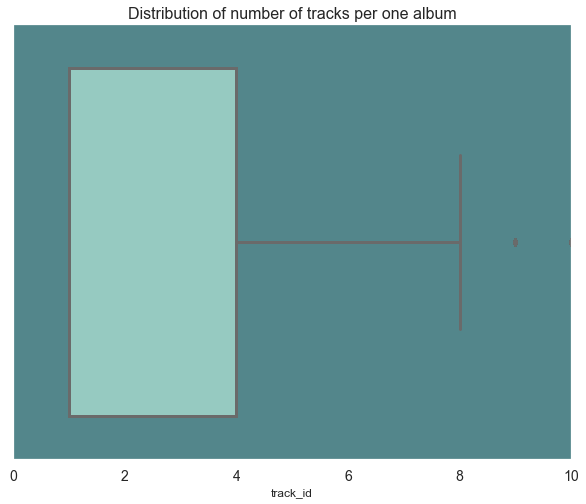

In [25]:
plt.title('Distribution of number of tracks per one album')
print("Median value: %s" % tracks.groupby('album_name')['track_id'].nunique().median())
ax = sns.boxplot(x=tracks.groupby('album_name')['track_id'].nunique())
ax.set_xlim(0, 10)
plt.show()

## Allcountries

In [26]:
allcountries = pd.read_csv(path + 'allcountries', compression = 'gzip', header = None, engine = 'python', quotechar="'", error_bad_lines=False)
allcountries.columns = ['device_type', 'length', 'os', 'timestamp', 'track_id', 'user_id']
allcountries['user_id'] = allcountries['user_id'].map(lambda x: x.split(':')[1].replace("{", "").replace("}", "").strip('"'))
allcountries['track_id'] = allcountries['track_id'].map(lambda x: x.split(':')[1].replace("{", "").replace("}", "").strip('"'))
allcountries.head()

,device_type,length,os,timestamp,track_id,user_id
0,"{""device_type"":""mobile""","""length"":136","""os"":""iOS""","""timestamp"":1504923300000",c43ac11b86c603e40aad9a0fbe72d192c0c51ded,3db57275059923d98119850a6233d3c609a171a5
1,"{""device_type"":""desktop""","""length"":60","""os"":""Browser""","""timestamp"":1504951200000",eee087bddc7db49cde2d43df7a04f3975dff4a78,0495eb11e3ca80c0289d3a08b5c60f0227e12314
2,"{""device_type"":""mobile""","""length"":191","""os"":""iOS""","""timestamp"":1504944900000",45e8fe7c02519b99b9284717cd3488eab2ef798e,b3d9fb538674878162e5a93566195daf878723db
3,"{""device_type"":""desktop""","""length"":268","""os"":""other""","""timestamp"":1504980900000",eb1016ee12dc5a3ada044b7dacb716049ed121c8,4831658d8f436e8c6ecf29984c405521de26e654
4,"{""device_type"":""mobile""","""length"":212","""os"":""Android""","""timestamp"":1504916100000",863af142e7604488cfd8f2245b65c9e6cafcd201,e1a1bb65848f54f266273caad9a327d13397889f


In [27]:
print("Data shape:")
allcountries.shape

Data shape:


(4313582, 6)

In [28]:
print("One row per user:")
allcountries.shape[0] == allcountries['track_id'].nunique(), allcountries.shape[0] == allcountries['user_id'].nunique()

One row per user:


(False, False)

In [29]:
print("Unique values:")
allcountries.nunique()

Unique values:


device_type          3
length             870
os                   8
timestamp           96
track_id         83426
user_id        1787756
dtype: int64

### Number of tracks per user

Median value: 1.0


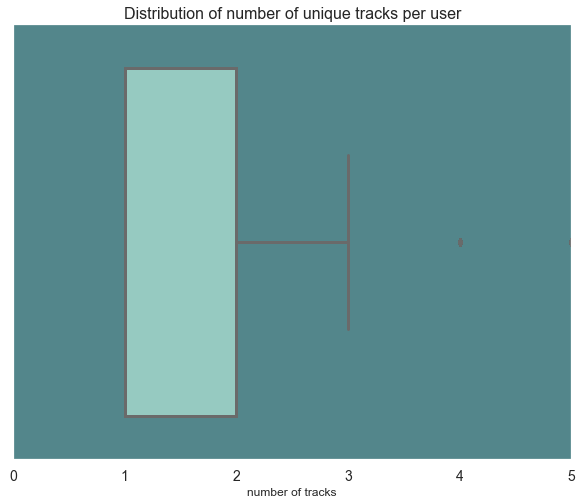

In [30]:
plt.title('Distribution of number of unique tracks per user')
user_track_unique = allcountries.groupby('user_id')['track_id'].nunique()
print("Median value: %s" % user_track_unique.median())
ax = sns.boxplot(x=user_track_unique)
ax.set_xlim(0, 5)
plt.xlabel('number of tracks')
plt.show()

#### Check if we have some suspicious outliers (extreme number of unique tracks)

In [31]:
user_track_unique.describe([.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99, .999])

count   1,787,756.00
mean            1.77
std             4.11
min             1.00
1%              1.00
10%             1.00
20%             1.00
30%             1.00
40%             1.00
50%             1.00
60%             1.00
70%             1.00
80%             2.00
90%             3.00
99%            11.00
99.9%          36.00
max           593.00
Name: track_id, dtype: float64

#### Check how many users with tracks more than 3

In [32]:
print("There are only %s users with number of tracks more than 3" % user_track_unique[user_track_unique > 3].shape[0])

There are only 136384 users with number of tracks more than 3


#### Save statistics

In [33]:
user_track_unique = user_track_unique[user_track_unique > 3]

### Streams by OS

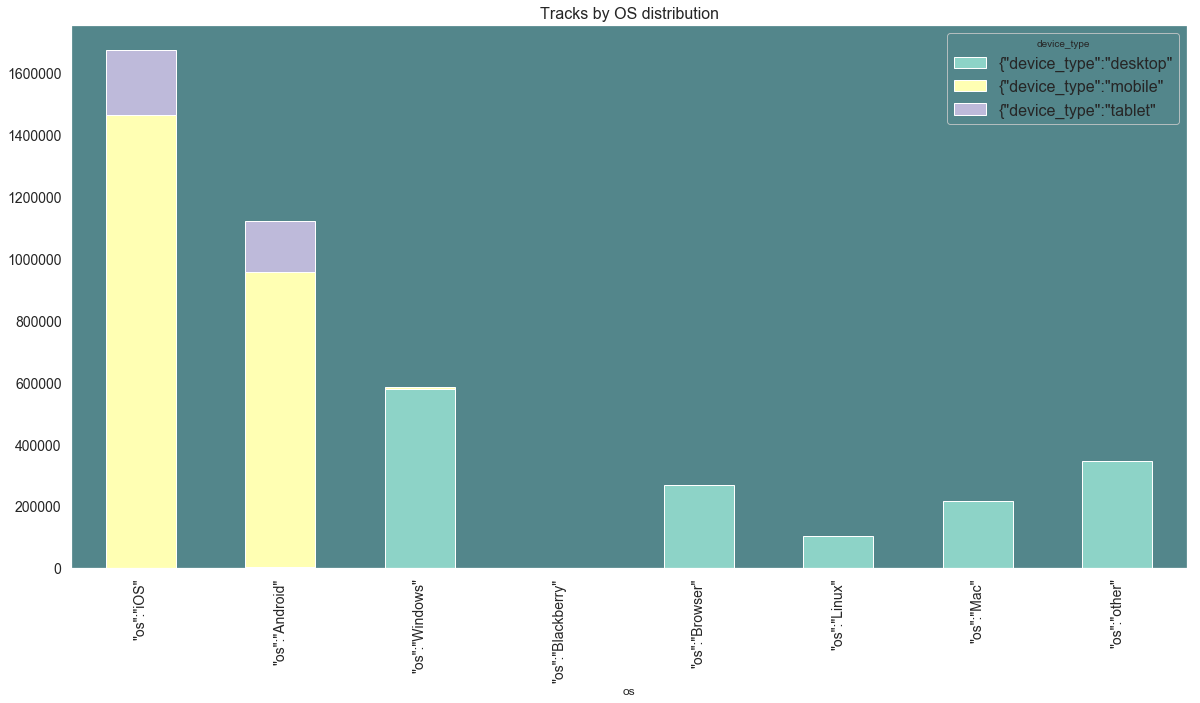

In [34]:
s = allcountries.groupby(['os', 'device_type']).size().reset_index().pivot(columns='device_type', index='os', values=0).fillna(0)
s.sort_values(by = ['{"device_type":"mobile"'], ascending = False).plot(kind='bar', stacked=True, figsize = (20, 10))
plt.title('Tracks by OS distribution')
plt.xticks(rotation = 90)
plt.show()

### Users by OS

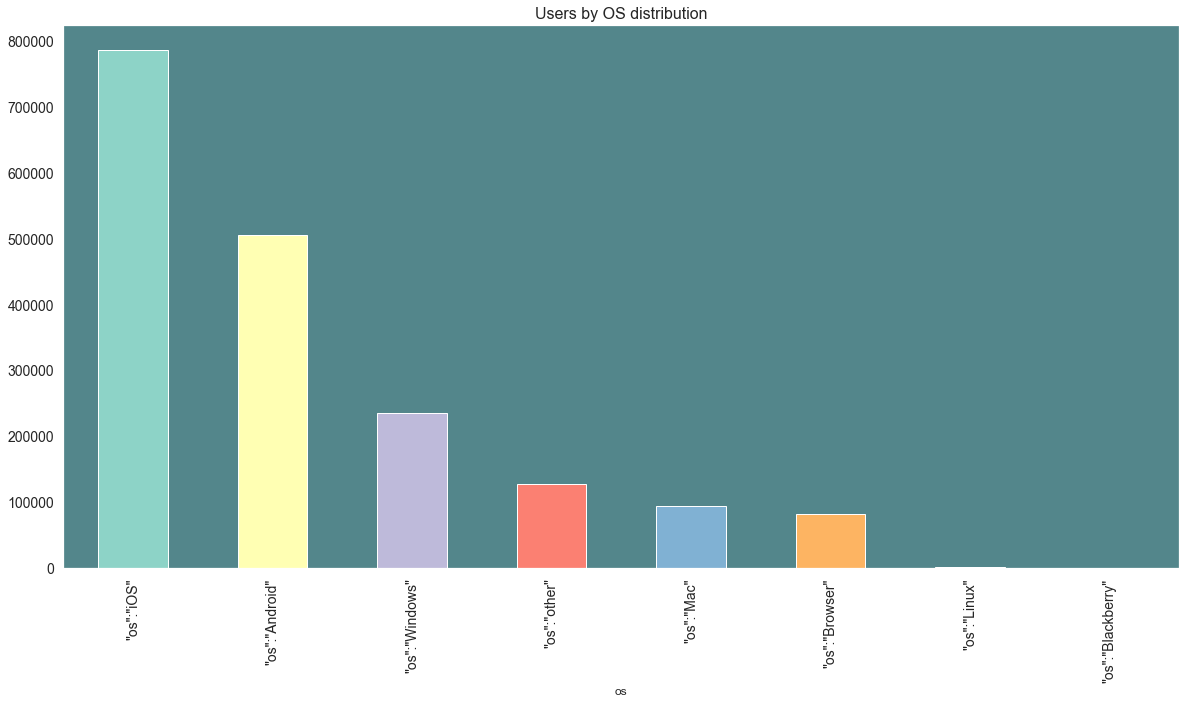

In [35]:
plt.title('Users by OS distribution')
allcountries.groupby('os')['user_id'].nunique().sort_values(ascending = False).plot(kind = 'bar', figsize  = (20, 10))
plt.xticks(rotation = 90)
plt.show()

### Tracks by OS

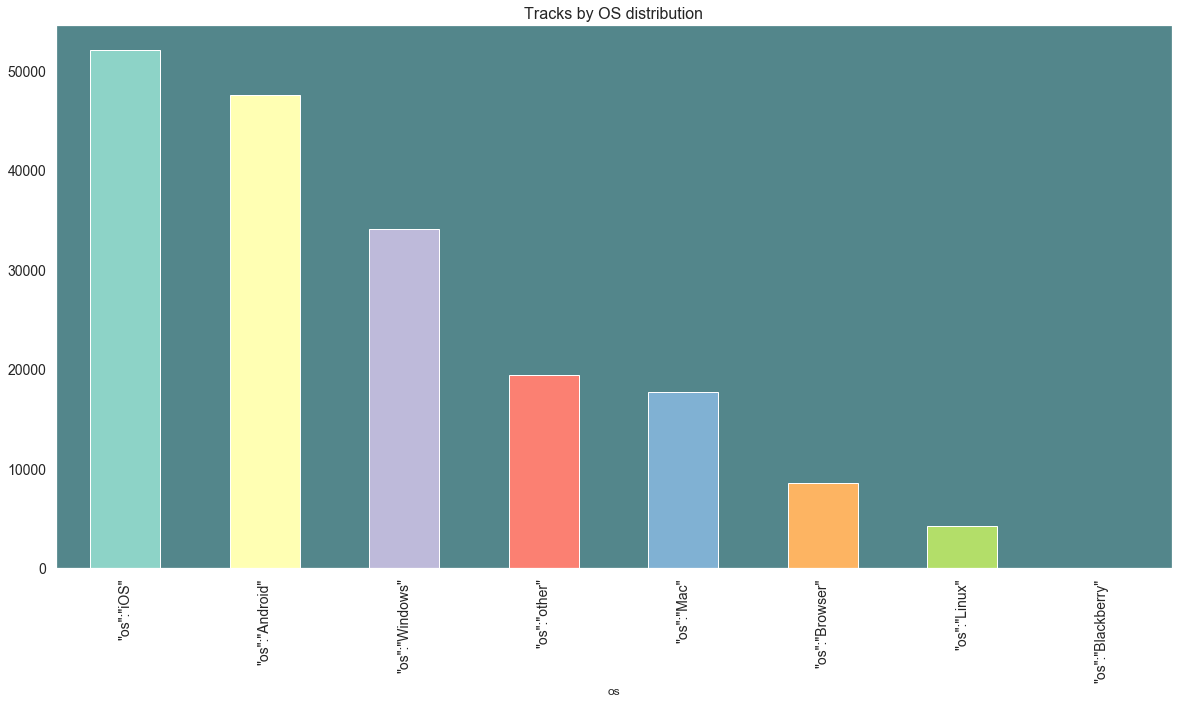

In [36]:
plt.title('Tracks by OS distribution')
allcountries.groupby('os')['track_id'].nunique().sort_values(ascending = False).plot(kind = 'bar', figsize  = (20, 10))
plt.xticks(rotation = 90)
plt.show()

### Distribution of streams per user

Median value: 1.0


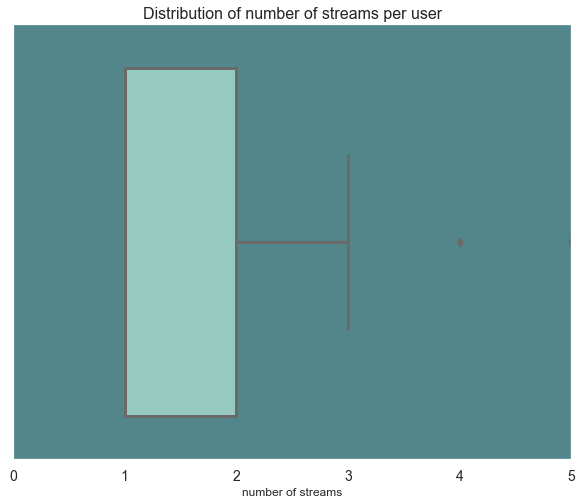

In [37]:
plt.title('Distribution of number of streams per user')
user_track_count = allcountries.groupby('user_id')['track_id'].count()
print("Median value: %s" % user_track_count.median())
ax = sns.boxplot(x=user_track_count)
ax.set_xlim(0, 5)
plt.xlabel('number of streams')
plt.show()

#### Check if we have some suspicious outliers (extreme number of streams)

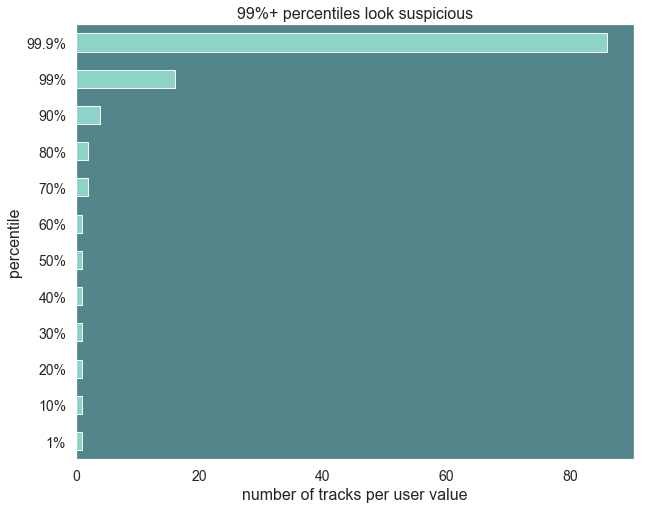

In [38]:
plt.title('99%+ percentiles look suspicious')
user_track_count.describe([.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99, .999])[4:-1].plot(kind = 'barh', color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
plt.xticks(rotation = 0)
plt.ylabel('percentile', fontsize = 16)
plt.xlabel('number of tracks per user value', fontsize = 16)
plt.show()

#### Check how many users with streams more than 4

In [39]:
print("There are only %s users with number of streams more than 100" % user_track_count[user_track_count > 4].shape[0])

There are only 148821 users with number of streams more than 100


#### Save statistics for further analysis

In [40]:
user_track_count = user_track_count[user_track_count > 4]

### Distribution of stream length

In [41]:
allcountries['length'] = allcountries['length'].map(lambda x: clean_text(x , 'numbers')).astype(int)

Median value: 172.0


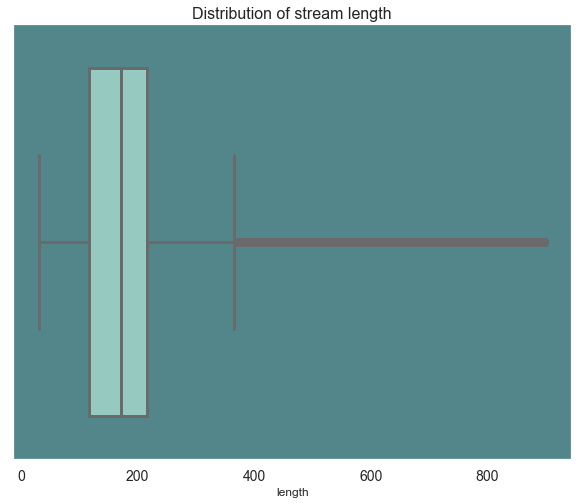

In [42]:
plt.title('Distribution of stream length')
print("Median value: %s" % allcountries['length'].median())
ax = sns.boxplot(x=allcountries['length'])
# ax.set_xlim(0, 10)
plt.show()

#### Check if we have some suspicious outliers (extreme length of streams)

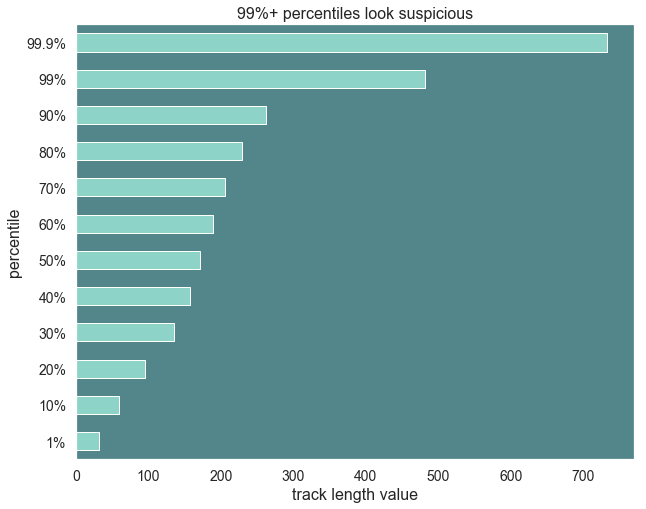

In [43]:
plt.title('99%+ percentiles look suspicious')
allcountries['length'].describe([.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99, .999])[4:-1].plot(kind = 'barh', color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
plt.xticks(rotation = 0)
plt.ylabel('percentile', fontsize = 16)
plt.xlabel('track length value', fontsize = 16)
plt.show()

#### Check how many users have length of streams more than 300

In [44]:
user_stream_length = allcountries.groupby('user_id')['length'].max()

In [45]:
print("There are only %s users with max length of streams more than 800" % user_stream_length[user_stream_length > 300].shape[0])

There are only 132322 users with max length of streams more than 800


#### Save statistics

In [46]:
user_stream_length = user_stream_length[user_stream_length > 300]

### DIstribution of number of devices per user

Median value: 1.0


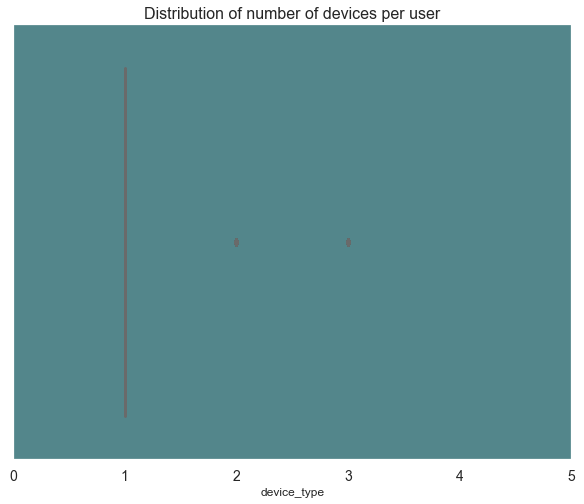

In [47]:
plt.title('Distribution of number of devices per user')
s = allcountries.groupby('user_id')['device_type'].nunique()
print("Median value: %s" % s.median())
ax = sns.boxplot(x=s)
ax.set_xlim(0, 5)
plt.show()

### Distribution of track length for different OS

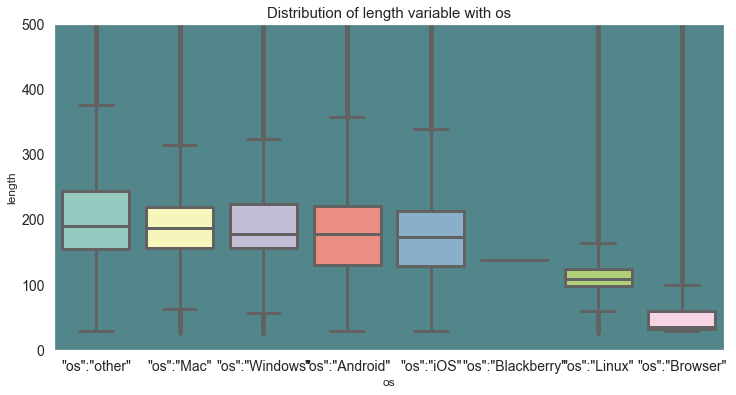

In [48]:
x_name = 'os'
y_name = 'length'
col_order = allcountries.groupby(x_name)[y_name].mean().sort_values(ascending = False).index.tolist()
plt.figure(figsize=(12,6))
ax = sns.boxplot(x=x_name, y=y_name, data=allcountries, order=col_order)
plt.xlabel(x_name, fontsize=12)
plt.ylabel(y_name, fontsize=12)
plt.title("Distribution of %s variable with %s" % (y_name, x_name), fontsize=15)
ax.set_ylim(0, 500)
plt.show()

### Distribution of track length for different device types

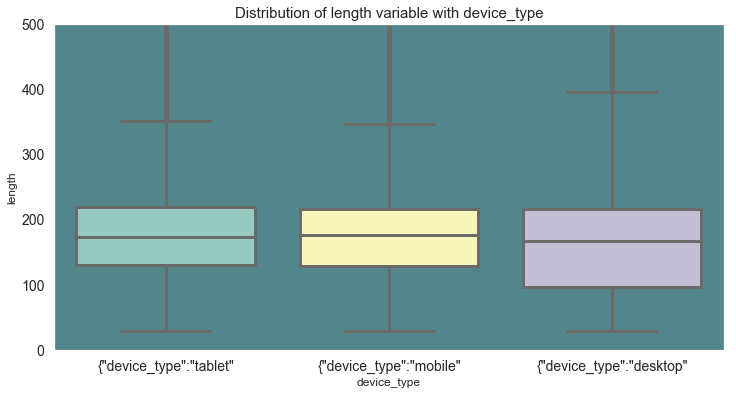

In [49]:
x_name = 'device_type'
y_name = 'length'
col_order = allcountries.groupby(x_name)[y_name].mean().sort_values(ascending = False).index.tolist()
plt.figure(figsize=(12,6))
ax = sns.boxplot(x=x_name, y=y_name, data=allcountries, order=col_order)
plt.xlabel(x_name, fontsize=12)
plt.ylabel(y_name, fontsize=12)
plt.title("Distribution of %s variable with %s" % (y_name, x_name), fontsize=15)
ax.set_ylim(0, 500)
plt.show()

### Distribution of gap between streams for users

In [50]:
allcountries = allcountries.sort_values(by = ['user_id', 'timestamp'])

allcountries['timestamp'] = allcountries['timestamp'].map(lambda x: clean_text(x , 'numbers')[:10]).astype(int)
allcountries['timestamp_previous'] = allcountries.groupby('user_id', sort = False)['timestamp'].shift(1)

# allcountries['timestamp'] = pd.to_datetime(allcountries['timestamp'],unit='s')
# allcountries['timestamp_previous'] = pd.to_datetime(allcountries['timestamp_previous'],unit='s')

allcountries['gap'] = allcountries['timestamp'] - allcountries['timestamp_previous']

# convert gaps to minutes units
allcountries['gap'] = allcountries['gap'] / (60)

In [51]:
allcountries[allcountries['gap'].notnull()]['gap'].describe()

count   2,525,826.00
mean           79.58
std           173.72
min             0.00
25%             0.00
50%            15.00
75%            60.00
max         1,425.00
Name: gap, dtype: float64

Median value: 15 minutes


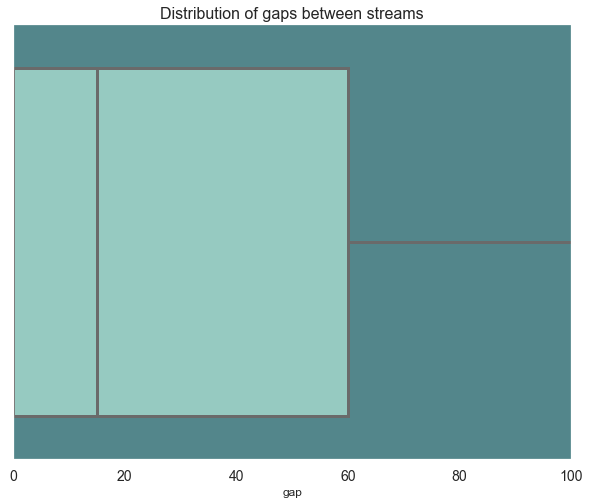

In [52]:
plt.title('Distribution of gaps between streams')
user_gap_stat = allcountries[allcountries['gap'].notnull()]['gap']
print("Median value: %s minutes" % int(user_gap_stat.median()))
ax = sns.boxplot(x=user_gap_stat)
ax.set_xlim(0, 100)
plt.show()

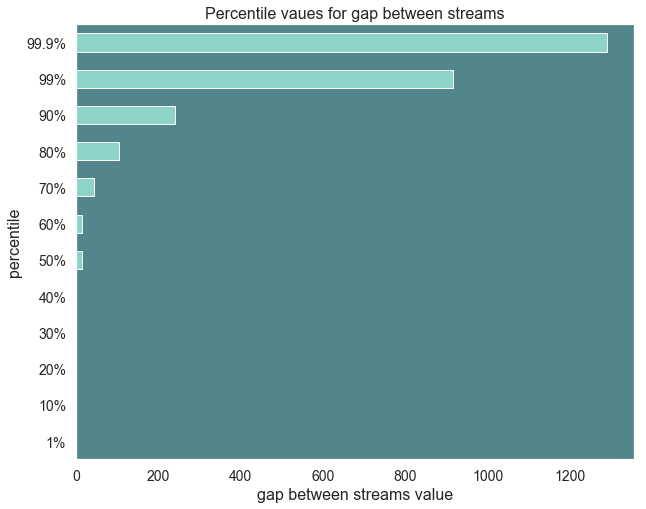

In [53]:
plt.title('Percentile vaues for gap between streams')
user_gap_stat.describe([.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99, .999])[4:-1].plot(kind = 'barh', color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
plt.xticks(rotation = 0)
plt.ylabel('percentile', fontsize = 16)
plt.xlabel('gap between streams value', fontsize = 16)
plt.show()

#### Check for users who have 0 median gap between streams

In [54]:
user_gap_stat = allcountries[allcountries['gap'].notnull()].groupby('user_id')['gap'].median()

In [55]:
print("There are only %s users with median gap between streams equal 0" % user_gap_stat[user_gap_stat == 0].shape[0])

There are only 118947 users with median gap between streams equal 0


#### Save statistics

In [56]:
user_gap_stat = user_gap_stat[user_gap_stat == 0]

### Dependency between stream length and gap between streams

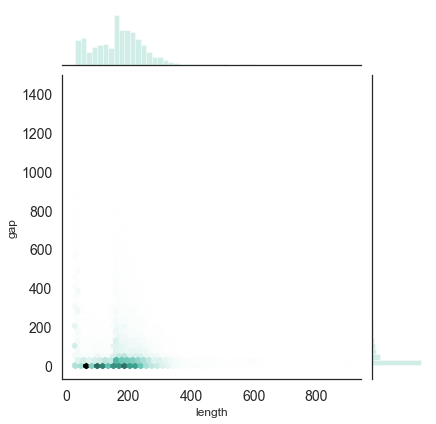

In [57]:
with sns.axes_style('white'):
    sns.jointplot("length", "gap", allcountries, kind='hex')

### Dependency between stream length and number of streams

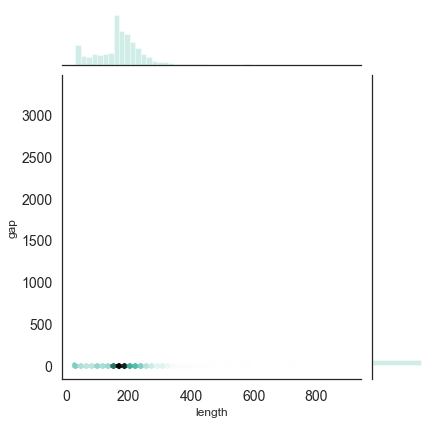

In [58]:
s  = allcountries.groupby('user_id')["length", "gap"].agg({'length' : 'mean', 'gap' : 'count'}).reset_index()
with sns.axes_style('white'):
    sns.jointplot("length", "gap", s, kind='hex')

## Fast check if users with huge number of streams are the same as users with small gap between streams and huge length of streams

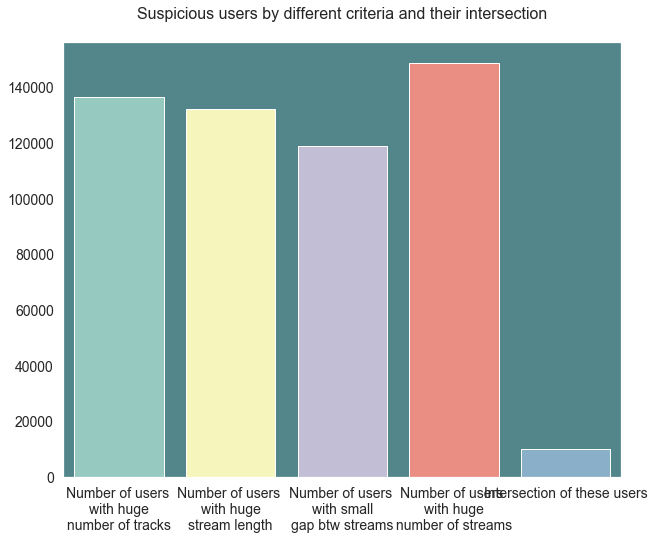

In [59]:
plt.title('Suspicious users by different criteria and their intersection\n')

ax = sns.barplot(['Number of users \nwith huge\nnumber of tracks',
                   'Number of users \nwith huge\nstream length',
                  'Number of users \nwith small\ngap btw streams',
                  'Number of users \nwith huge\nnumber of streams',
                 'Intersection of these users'], 
                 [user_track_unique.shape[0], user_stream_length.shape[0], user_gap_stat.shape[0], user_track_count.shape[0], 
                  len(set(user_track_unique.index) & set(user_stream_length.index) & set(user_gap_stat.index) & set(user_track_count.index))])
plt.show()

In [60]:
users_suspicious = list(set(user_track_unique.index) & set(user_stream_length.index) & set(user_gap_stat.index) & set(user_track_count.index))

In [61]:
print('Number of suspicious users: {0}'.format(len(users_suspicious)))

print('Percentage of suspicious users from total: {0:0.1f}%'.format(100*len(users_suspicious) / allcountries['user_id'].nunique()))

Number of suspicious users: 9959
Percentage of suspicious users from total: 0.6%


## Calculate statistics for users to train One-class classifier to find outliers

### Generate statistics for users

In [62]:
allusers = users[['user_id', 'gender', 'age', 'access', 'country']].copy()

allusers['gender'] = (allusers['gender'] == 'gender:"female"')*1

for i, t in enumerate(top_countries):
    allusers['top_country_' + str(i)] = (allusers['country'] == t)*1
allusers.drop(['country'], axis = 1, inplace = True)
              
for i, t in enumerate(['{"access":"free"', '{"access":"premium"']):
    allusers['access_' + str(i)] = (allusers['access'] == t)*1
allusers.drop(['access'], axis = 1, inplace = True)

allusers['user_track_unique'] = allusers['user_id'].map(allcountries.groupby('user_id')['track_id'].nunique())

allusers['user_stream_length_mean'] = allusers['user_id'].map(allcountries.groupby('user_id')['length'].mean())

allusers['user_gap_mean'] = \
allusers['user_id'].map(allcountries[allcountries['gap'].notnull()].groupby('user_id')['gap'].mean()).fillna(0)

allusers['user_track_count'] = allusers['user_id'].map(allcountries.groupby('user_id')['track_id'].count())

track_stat = allcountries['track_id'].value_counts().reset_index()
track_stat.columns = ['track_id', 'total_count']
user_track = allcountries.groupby(['user_id', 'track_id'])['device_type'].count().reset_index()\
.rename(columns = {'device_type' : 'user_count'})
user_track = pd.merge(user_track, track_stat, how = 'inner', on = 'track_id')

user_track['user_share'] = user_track['user_count'] / user_track['total_count']

allusers['user_track_mean_share'] = allusers['user_id'].map(user_track.groupby('user_id')['user_share'].mean())

In [63]:
mean_dict = {}
std_dict = {}

for col in allusers.columns[9:]:
    mean = allusers[col].mean()
    std = allusers[col].std()
    allusers[col] = (allusers[col] - mean) / std
    mean_dict[col] = mean
    std_dict[col] = std
    print(col)

user_track_unique
user_stream_length_mean
user_gap_mean
user_track_count
user_track_mean_share


In [64]:
allusers.tail()

,user_id,gender,age,top_country_0,top_country_1,top_country_2,top_country_3,access_0,access_1,user_track_unique,user_stream_length_mean,user_gap_mean,user_track_count,user_track_mean_share
1787751,fb8315fb3385f0ee6ba6fc7437c9af002ed362c6,0,27,0,0,0,0,1,0,0.06,1.44,-0.37,-0.03,-0.18
1787752,fc1f98c253c5556773f3632b1f4ec2e2d14b793b,1,21,0,0,0,0,1,0,-0.19,-1.50,-0.37,-0.10,-0.19
1787753,8988962c5ac51633a27ed89a9b7f26a342cd594a,0,28,0,0,0,0,1,0,-0.19,-1.75,-0.37,-0.10,-0.15
1787754,01145c552ba2baf0cd3fd7697410eda8fee920a1,1,32,0,1,0,0,0,1,0.06,-1.13,-0.37,-0.03,0.02
1787755,d709f727c9d1b8d6fa90991fd412017bdd0786c8,1,19,0,0,0,0,0,1,-0.19,0.09,-0.37,-0.10,-0.18


In [65]:
clf = IsolationForest(contamination=0.3, n_jobs = -1, random_state = 0, max_features = allusers.iloc[:, 1:].shape[1])
clf.fit(allusers.iloc[:, 1:])

IsolationForest(bootstrap=False, contamination=0.3, max_features=13,
        max_samples='auto', n_estimators=100, n_jobs=-1, random_state=0,
        verbose=0)

In [66]:
allusers['outlier'] = (clf.predict(allusers.iloc[:, 1:]) == -1)*1

#### It is important that outliers have suspicious number of tracks

In [67]:
allusers['outlier'] = ((abs(allusers['user_track_unique']) > 2) & \
                       (abs(allusers['user_track_count']) > 2) & (allusers['outlier'] == 1))*1

In [68]:
allusers['outlier'].value_counts()

0    1782915
1       4841
Name: outlier, dtype: int64

In [69]:
print('Intersection with manually detected fraudsters: ', \
    len(set(allusers[allusers['outlier'] == 1]['user_id'].values) & set(users_suspicious)) / len(users_suspicious))

Intersection with manually detected fraudsters:  0.14931217993774476


In [70]:
allusers[allusers['outlier'] == 1].head(10)

,user_id,gender,age,top_country_0,top_country_1,top_country_2,top_country_3,access_0,access_1,user_track_unique,user_stream_length_mean,user_gap_mean,user_track_count,user_track_mean_share,outlier
502,7d486e1321f8f4d0bba841c934fc9ab4629d26ce,0,28,0,1,0,0,0,1,4.19,0.04,-0.28,2.05,0.01,1
593,524a149eeda0eefa1bf4165f8c33a0213ef1681a,1,51,0,0,0,0,0,1,6.87,-0.50,-0.37,2.12,-0.18,1
2202,3829699e1a7369115fbd920e257d3ce4f6b4dd9d,0,53,0,1,0,0,0,1,5.65,0.12,-0.24,2.64,0.04,1
2850,ed136c02c74c5fac95ab4ea3661d749b8f2170fc,0,41,0,1,0,0,1,0,2.25,-1.42,-0.22,3.09,0.02,1
2902,e52172b0ad5ccf6232306c3dc7992ec151cd5543,1,27,0,0,0,0,1,0,55.51,-0.85,-0.36,136.42,0.11,1
3066,e4855cf0abda616c15423c6b46a5f6eab5b602d5,0,22,0,0,1,0,0,1,4.43,0.31,-0.37,2.79,-0.14,1
3604,44ac8d3c188beb43a79d8517e36429b6c6eabfab,0,24,0,0,0,0,0,1,8.08,-0.62,-0.22,2.57,-0.07,1
3657,431602c95cec1267fbf8797a86faaf231f6167b7,0,37,1,0,0,0,0,1,51.62,-0.01,-0.33,19.35,-0.06,1
4028,054907f2b6ba119eae515cdaa8ddcc6884e38906,0,51,1,0,0,0,0,1,11.00,-0.46,-0.31,4.57,-0.17,1
4138,fcc132e62ff14bf9413a5f3fb41d806fdd29ba83,0,58,1,0,0,0,1,0,7.35,0.53,-0.34,22.69,4.30,1


In [71]:
users_suspicious = allusers[allusers['outlier'] == 1]['user_id'].unique()

#### possible number of outliers at step 1

In [72]:
print('Number of suspicious users: {0}'.format(allusers['outlier'].sum()))

print('Percentage of suspicious users from total: {0:0.1f}%'.format(100*allusers['outlier'].sum() / allcountries['user_id'].nunique()))

Number of suspicious users: 4841
Percentage of suspicious users from total: 0.3%


## Step 1 conclusions:

<div class="alert alert-block alert-warning">
<ul><b>
    <li style="font-size:20px">There are users with huge number of tracks</li>
    <li style="font-size:20px">There are users with huge number of streams</li>
    <li style="font-size:20px">There are users with huge length of streams</li>
    <li style="font-size:20px">There are users with 0 median gap between streams</li>
    <li style="font-size:20px">There are 6523 users that are suspiciously active</li>
    </b>
</ul>
</div>

# STEP 2: Track history

<div class="alert alert-block alert-warning">
<ul><b>
    <li style="font-size:20px">fraudulent users could have multiple accounts</li>
    </b>
</ul>
</div>

## Check if suspicious users have similar track history

In [73]:
user_track_s = allcountries[allcountries['user_id'].isin(users_suspicious)].groupby(['user_id', 'track_id'])['device_type'].count()\
.reset_index().rename(columns = {'device_type' : 'count'})

user_track_ns = allcountries[~allcountries['user_id'].isin(users_suspicious)].sample(frac = 0.02).groupby(['user_id', 'track_id'])['device_type'].count()\
.reset_index().rename(columns = {'device_type' : 'count'})

user_track = pd.concat([user_track_s, user_track_ns])

users_u = list(sorted(user_track.user_id.unique()))
track_u = list(sorted(user_track.track_id.unique()))

data = user_track['count'].tolist()
row = user_track.user_id.astype('category', categories=users_u).cat.codes
col = user_track.track_id.astype('category', categories=track_u).cat.codes
sparse_matrix = csr_matrix((data, (row, col)), shape=(len(users_u), len(track_u)))

In [74]:
sparse_matrix.shape

(75475, 27930)

In [75]:
svd = TruncatedSVD(n_components=30, n_iter=7, random_state=42)
svd.fit(sparse_matrix)  

print('Total explained variance: ', svd.explained_variance_ratio_.sum())  

Total explained variance:  0.8086910697420997


In [76]:
tsne = TSNE(n_components=2, random_state=0, perplexity=20)

X_2d = TSNE(n_jobs=12).fit_transform(svd.transform(sparse_matrix))

tsne_df  = pd.DataFrame({'TSNE component 1' : X_2d[:, 0], 'TSNE component 2' : X_2d[:, 1], 'user_id' : users_u})
tsne_df['suspicious'] = tsne_df['user_id'].isin(users_suspicious)*1

tsne_df['suspicious'] = tsne_df['suspicious'].map({0 : 'not suspicious', 1 : 'suspicious'})

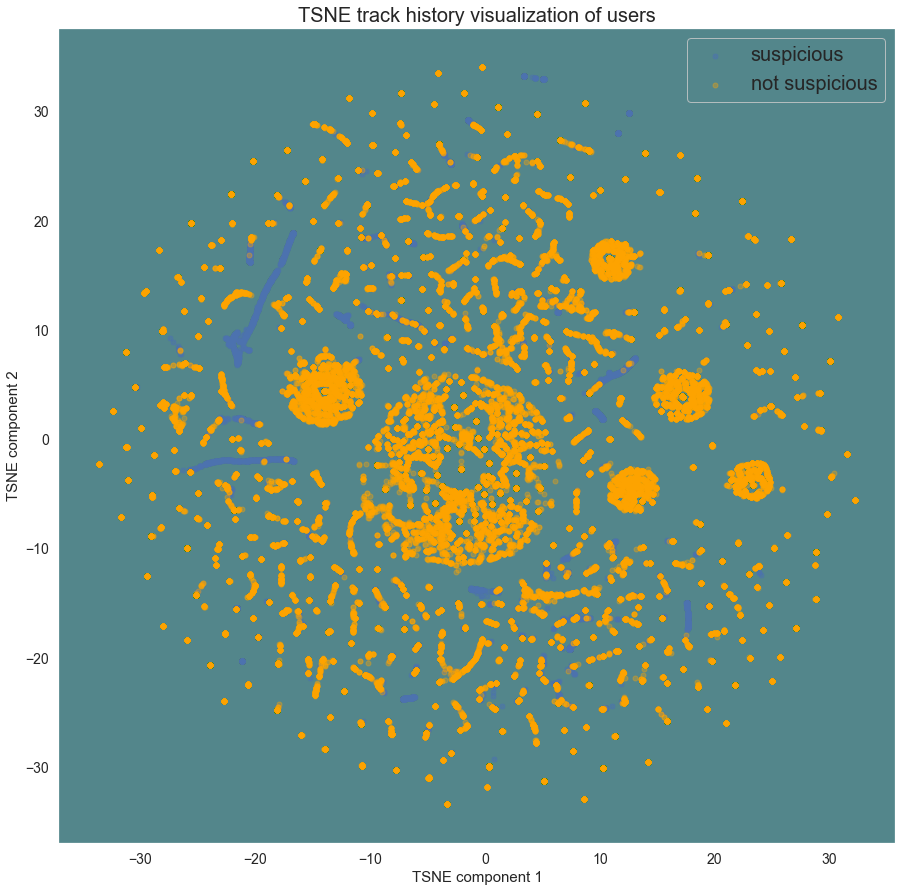

In [77]:
#Now we jsut plot a scatter plot
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('TSNE component 1', fontsize = 15)
ax.set_ylabel('TSNE component 2', fontsize = 15)
ax.set_title('TSNE track history visualization of users', fontsize = 20)

targets = ['suspicious', 'not suspicious']
colors = ['b', 'orange']
for target, color, alpha in zip(targets,colors, [0.25, 0.1]):

    indicesToKeep = tsne_df['suspicious'] == target

    ax.scatter(tsne_df.loc[indicesToKeep, 'TSNE component 1']
               , tsne_df.loc[indicesToKeep, 'TSNE component 2']
               , c = color
               , s = 25,alpha=0.25 + alpha)

ax.legend(targets, fontsize = 20)
ax.grid()

plt.show()

## Fraudsters could try to promote rare tracks that have little number of streams by other users

In [78]:
track_stat = allcountries['track_id'].value_counts().reset_index()
track_stat.columns = ['track_id', 'total_count']
user_track = allcountries.groupby(['user_id', 'track_id'])['device_type'].count().reset_index()\
.rename(columns = {'device_type' : 'user_count'})
user_track = pd.merge(user_track, track_stat, how = 'inner', on = 'track_id')

Median value: 3


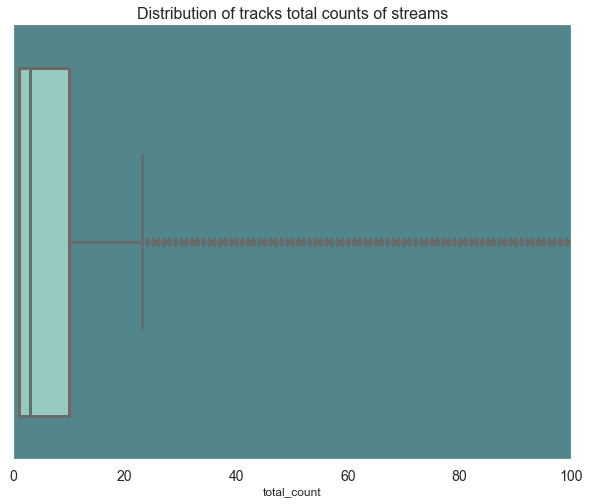

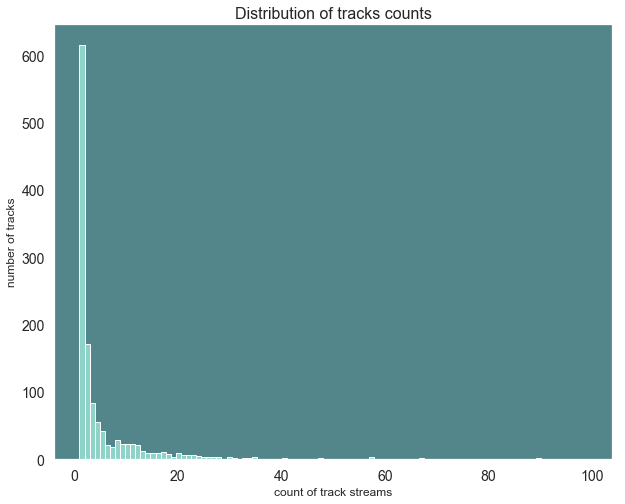

In [79]:
plt.title('Distribution of tracks total counts of streams', fontsize = 16)
print("Median value: %s" % int(track_stat['total_count'].median()))
ax = sns.boxplot(x=track_stat['total_count'])
ax.set_xlim(0, 100)
plt.show()

plt.title('Distribution of tracks counts', fontsize = 16)
t = track_stat.groupby('total_count')['track_id'].nunique()
t[t < 100].hist(bins = 100)
plt.xlabel('count of track streams')
plt.ylabel('number of tracks')
plt.show()

### Users tend to listen different tracks but some of them listen only few

In [80]:
user_track['suspicious'] = user_track['user_id'].isin(users_suspicious)*1
user_track['user_share'] = user_track['user_count'] / user_track['total_count']

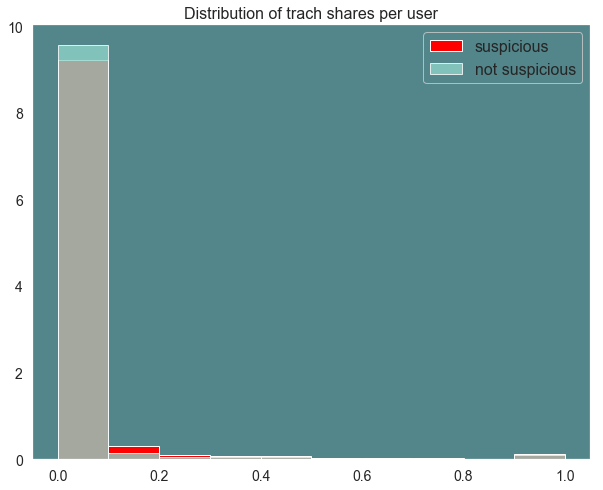

In [81]:
plt.title('Distribution of trach shares per user')
user_track[user_track['suspicious'] == 1]['user_share'].hist(label = 'suspicious', normed = True, color = 'red')
user_track[user_track['suspicious'] == 0]['user_share'].hist(label = 'not suspicious', normed = True, alpha = 0.8)
plt.legend(loc = 'upper right', fontsize = 16)
plt.show()

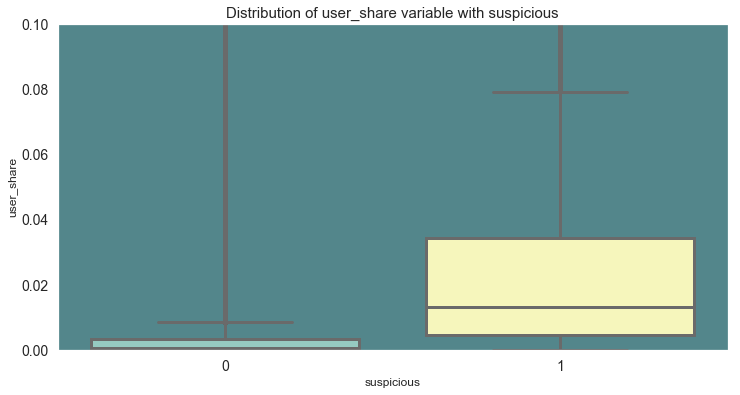

In [82]:
x_name = 'suspicious'
y_name = 'user_share'
col_order = np.sort(user_track[x_name].unique()).tolist()
plt.figure(figsize=(12,6))
ax= sns.boxplot(x=x_name, y=y_name, data=user_track, order=col_order)
ax.set_ylim(0, 0.1)
plt.xlabel(x_name, fontsize=12)
plt.ylabel(y_name, fontsize=12)
plt.title("Distribution of %s variable with %s" % (y_name, x_name), fontsize=15)
plt.show()

## For each user we receive track embeddings

### Deep learning for user emdeddings

In [83]:
user_track.head()

,user_id,track_id,user_count,total_count,suspicious,user_share
0,00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,45e8fe7c02519b99b9284717cd3488eab2ef798e,1,117535,0,0.00
1,0000cfa27c54f3a9c1bca6ec656a52926c52d234,45e8fe7c02519b99b9284717cd3488eab2ef798e,1,117535,0,0.00
2,00012873b0a82e81b3155431769fa5ac0a8ac267,45e8fe7c02519b99b9284717cd3488eab2ef798e,1,117535,0,0.00
3,000134b94b87f70dc30597aa19598fbeaa70dc7f,45e8fe7c02519b99b9284717cd3488eab2ef798e,1,117535,0,0.00
4,00015babedef955867a39cd602388fe44b3d4362,45e8fe7c02519b99b9284717cd3488eab2ef798e,1,117535,0,0.00


In [84]:
def label_dict(series):
    counter = 0
    dicty = {}
    dicty_back = {}
    for uniq in series.unique():
        dicty[uniq] = counter
        dicty_back[counter] = uniq
        counter += 1
    return dicty, dicty_back

In [85]:
user_dict, user_dict_back = label_dict(user_track['user_id'])
user_track['user_id'] = user_track['user_id'].map(user_dict)

In [86]:
track_dict, track_dict_back = label_dict(user_track['track_id'])
user_track['track_id'] = user_track['track_id'].map(track_dict)

In [87]:
train, test = train_test_split(user_track, test_size=0.2, random_state = 0)

In [88]:
train.user_id.nunique()

1514033

In [89]:
y_true = test.user_count

In [90]:
n_latent_factors_user = 8
n_latent_factors_movie = 10
n_latent_factors_mf = 3
n_users, n_movies = len(user_track.user_id.unique()), len(user_track.track_id.unique())

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding_mlp = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding-MLP')(movie_input)
movie_vec_mlp = keras.layers.Flatten(name='FlattenMovies-MLP')(movie_embedding_mlp)
movie_vec_mlp = keras.layers.Dropout(0.2)(movie_vec_mlp)

movie_embedding_mf = keras.layers.Embedding(n_movies + 1, n_latent_factors_mf, name='Movie-Embedding-MF')(movie_input)
movie_vec_mf = keras.layers.Flatten(name='FlattenMovies-MF')(movie_embedding_mf)
movie_vec_mf = keras.layers.Dropout(0.2)(movie_vec_mf)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec_mlp = keras.layers.Flatten(name='FlattenUsers-MLP')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding-MLP')(user_input))
user_vec_mlp = keras.layers.Dropout(0.2)(user_vec_mlp)

user_vec_mf = keras.layers.Flatten(name='FlattenUsers-MF')(keras.layers.Embedding(n_users + 1, n_latent_factors_mf,name='User-Embedding-MF')(user_input))
user_vec_mf = keras.layers.Dropout(0.2)(user_vec_mf)

concat = keras.layers.merge.concatenate([movie_vec_mlp, user_vec_mlp],name='Concat')
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected')(concat_dropout)
dense_batch = keras.layers.BatchNormalization(name='Batch')(dense)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout-1')(dense_batch)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(dropout_1)
dense_batch_2 = keras.layers.BatchNormalization(name='Batch-2')(dense_2)


dropout_2 = keras.layers.Dropout(0.2,name='Dropout-2')(dense_batch_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dropout_2)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)

pred_mf = keras.layers.merge.dot([movie_vec_mf, user_vec_mf], axes = 1, name='Dot')
pred_mlp = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)

combine_mlp_mf = keras.layers.merge.concatenate([pred_mf, pred_mlp], name='Concat-MF-MLP')
result_combine = keras.layers.Dense(100,name='Combine-MF-MLP')(combine_mlp_mf)
deep_combine = keras.layers.Dense(100,name='FullyConnected-4')(result_combine)


result = keras.layers.Dense(1,name='Prediction')(deep_combine)


model = keras.Model([user_input, movie_input], result)
opt = keras.optimizers.Adam(lr =0.01)
model.compile(optimizer='adam',loss= 'mean_absolute_error', metrics=['mae'])

In [91]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding-MLP (Embedding) (None, 1, 10)        834270      Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding-MLP (Embedding)  (None, 1, 8)         14302056    User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [92]:
callbacks = [
keras.callbacks.EarlyStopping(monitor='mean_absolute_error', min_delta=0, patience=5, verbose=1, mode='auto', baseline=None, restore_best_weights=True)
]

In [93]:
history = model.fit([train.user_id, train.track_id], train.user_count, epochs=10, verbose=2, validation_split = 0.05, batch_size = 2048,
                   callbacks = callbacks)

Train on 2401915 samples, validate on 126417 samples
Epoch 1/10
 - 34s - loss: 0.3806 - mean_absolute_error: 0.3806 - val_loss: 0.3881 - val_mean_absolute_error: 0.3881
Epoch 2/10
 - 31s - loss: 0.3704 - mean_absolute_error: 0.3704 - val_loss: 0.3967 - val_mean_absolute_error: 0.3967
Epoch 3/10
 - 31s - loss: 0.3696 - mean_absolute_error: 0.3696 - val_loss: 0.3865 - val_mean_absolute_error: 0.3865
Epoch 4/10
 - 31s - loss: 0.3495 - mean_absolute_error: 0.3495 - val_loss: 0.3646 - val_mean_absolute_error: 0.3646
Epoch 5/10
 - 31s - loss: 0.3438 - mean_absolute_error: 0.3438 - val_loss: 0.3611 - val_mean_absolute_error: 0.3611
Epoch 6/10
 - 31s - loss: 0.3404 - mean_absolute_error: 0.3404 - val_loss: 0.3577 - val_mean_absolute_error: 0.3577
Epoch 7/10
 - 31s - loss: 0.3369 - mean_absolute_error: 0.3369 - val_loss: 0.3568 - val_mean_absolute_error: 0.3568
Epoch 8/10
 - 31s - loss: 0.3337 - mean_absolute_error: 0.3337 - val_loss: 0.3549 - val_mean_absolute_error: 0.3549
Epoch 9/10
 - 32s -

In [94]:
# model.save_weights('keras_embeddings.h5')

In [95]:
y_hat = np.round(model.predict([test.user_id, test.track_id]),0)

In [96]:
y_hat[y_hat < 1] = 1
print(mean_absolute_error(y_true, y_hat))

0.3199152642928223


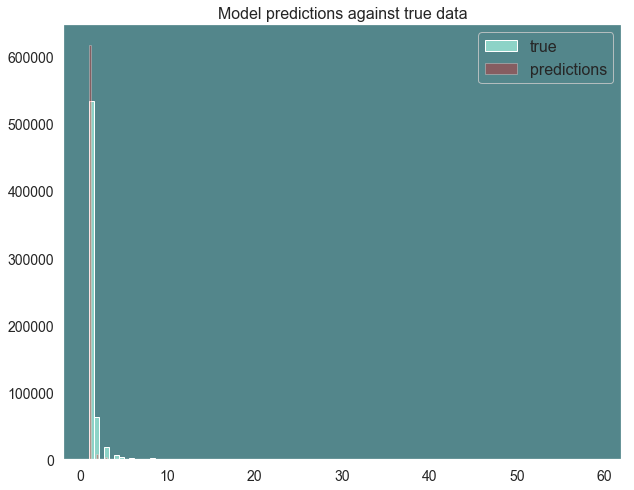

In [97]:
plt.title('Model predictions against true data')
s = pd.Series(y_hat.flatten())
y_true[y_true < 60].hist(bins = 100, label = 'true')
s[s < 60].hist(bins = 100, label = 'predictions', alpha = 0.3, color = 'red')
plt.legend()
plt.show()

In [98]:
user_list = pd.DataFrame({'user_id' : user_track['user_id'].unique()})
user_list['track_id'] = 1

In [99]:
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer('User-Embedding-MLP').output)
intermediate_output = intermediate_layer_model.predict([user_list.user_id, user_list.track_id])

In [100]:
intermediate_output = intermediate_output.reshape(intermediate_output.shape[0], intermediate_output.shape[2])

In [101]:
for i in range(intermediate_output.shape[1]):
    user_list['vector_' + str(i+1)] = intermediate_output[:, i]

In [102]:
user_list['user_id'] = user_list['user_id'].map(user_dict_back)
user_list.drop('track_id', axis = 1, inplace = True)

In [103]:
user_list.head()

,user_id,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8
0,00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,0.03,-0.03,0.05,0.01,-0.04,-0.04,0.04,0.02
1,0000cfa27c54f3a9c1bca6ec656a52926c52d234,-0.02,0.00,-0.01,-0.02,0.04,-0.03,-0.01,0.03
2,00012873b0a82e81b3155431769fa5ac0a8ac267,0.00,-0.01,-0.02,-0.01,-0.02,0.01,-0.04,0.01
3,000134b94b87f70dc30597aa19598fbeaa70dc7f,-0.00,0.00,0.00,-0.04,-0.04,0.02,0.00,-0.02
4,00015babedef955867a39cd602388fe44b3d4362,0.03,0.01,0.04,-0.03,-0.02,0.03,0.00,0.00


## Print all users in 2d space

In [104]:
cols = [c for c in user_list.columns if 'vector' in c]

In [105]:
pca = PCA(n_components=2)
pca.fit(user_list[cols])

print(pca.explained_variance_ratio_.sum())  

0.26505678645699454


In [106]:
X_2d = pca.transform(user_list[cols])

pca_df  = pd.DataFrame({'PCA component 1' : X_2d[:, 0], 'PCA component 2' : X_2d[:, 1], 'user_id' : user_list['user_id']})
pca_df['suspicious'] = pca_df['user_id'].isin(users_suspicious)*1

pca_df['suspicious'] = pca_df['suspicious'].map({0 : 'not suspicious', 1 : 'suspicious'})

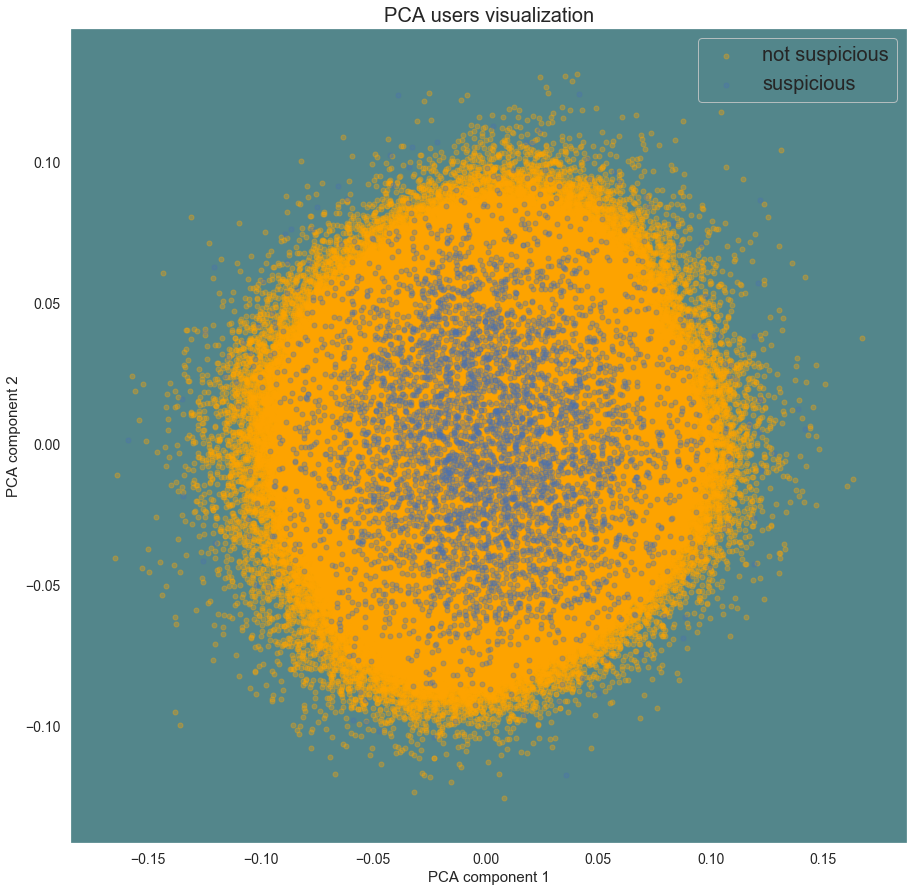

In [107]:
#Now we jsut plot a scatter plot
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('PCA component 1', fontsize = 15)
ax.set_ylabel('PCA component 2', fontsize = 15)
ax.set_title('PCA users visualization', fontsize = 20)

targets = ['not suspicious', 'suspicious']
colors = ['orange', 'b']
for target, color in zip(targets,colors):

    indicesToKeep = pca_df['suspicious'] == target

    ax.scatter(pca_df.loc[indicesToKeep, 'PCA component 1']
               , pca_df.loc[indicesToKeep, 'PCA component 2']
               , c = color
               , s = 25,alpha=0.35)

ax.legend(targets, fontsize = 20)
ax.grid()

plt.show()

## Similar users

### Based on deep learning embeddings

In [108]:
only_suspicious = user_list[user_list['user_id'].isin(allusers[allusers['outlier'] == 1]['user_id'].unique())]\
.reset_index(drop = True)
features_vec = only_suspicious.iloc[:, 1:].values

lshf = LSHForest(random_state=42, n_candidates=100, n_estimators=10, n_neighbors=5,
     radius=0.1)
lshf.fit(features_vec)

LSHForest(min_hash_match=4, n_candidates=100, n_estimators=10, n_neighbors=5,
     radius=0.1, radius_cutoff_ratio=0.9, random_state=42)

In [109]:
features_vec.shape

(4841, 8)

In [110]:
distances = lshf.radius_neighbors(features_vec, radius = 0.01)

index_match = only_suspicious.set_index(only_suspicious.index)['user_id'].to_dict()

neigbors = []

counter = 0
for d in distances[1]:
    if len(d) > 1:
        n = []
        for ii in d[1:]:
            n.append(index_match[ii])
        neigbors.append(n) 
        counter += 1
    else:
        neigbors.append([])

In [111]:
only_suspicious['possible_duplicate_accounts'] = neigbors
only_suspicious['n_duplicates'] = only_suspicious['possible_duplicate_accounts'].map(lambda x: len(x))

In [112]:
only_suspicious['n_duplicates'].mean()

0.0016525511258004544

In [113]:
only_suspicious[only_suspicious['n_duplicates'] > 0]

,user_id,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,possible_duplicate_accounts,n_duplicates
533,4e9341db519261a2035f252ecd0bd1dd0ce7ffea,0.04,-0.05,-0.06,0.03,-0.02,0.02,0.04,0.04,[b58741492daedc203e35a9b2bb886acb8a1fb10d],1
2227,f702e024ef8baf0d3c457d2f4e855f288aa89043,-0.04,0.01,0.04,-0.02,0.02,-0.01,-0.04,-0.04,[848979b7b0f308c1c26947b4a836f6aa92adf2d2],1
2343,848979b7b0f308c1c26947b4a836f6aa92adf2d2,-0.04,0.02,0.04,-0.02,0.02,-0.01,-0.04,-0.03,[f702e024ef8baf0d3c457d2f4e855f288aa89043],1
2571,42f6e846a0d59dff55025ca64eda9ba2fcab79b9,-0.01,-0.01,0.04,0.02,0.05,-0.02,-0.04,-0.02,[e52ad66d5d235ceee57074dacd7653ec030c842f],1
3697,9caa34f32be8bb5c09ce0d83ea2bf68dd14d7a9f,0.03,-0.03,0.01,-0.02,-0.06,0.05,0.04,-0.02,[76937aa5b32efc8783df802697532b3c775e4516],1
4313,e52ad66d5d235ceee57074dacd7653ec030c842f,-0.01,-0.00,0.04,0.01,0.05,-0.03,-0.04,-0.02,[42f6e846a0d59dff55025ca64eda9ba2fcab79b9],1
4544,b58741492daedc203e35a9b2bb886acb8a1fb10d,0.03,-0.04,-0.04,0.02,-0.01,0.02,0.04,0.03,[4e9341db519261a2035f252ecd0bd1dd0ce7ffea],1
4762,76937aa5b32efc8783df802697532b3c775e4516,0.02,-0.03,0.01,-0.02,-0.05,0.04,0.04,-0.01,[9caa34f32be8bb5c09ce0d83ea2bf68dd14d7a9f],1


In [114]:
len(set(allcountries[allcountries['user_id'] == '1bdd46e5ca1c79082c210c7eacc046d8ec2a62ce']['track_id'].unique()) & \
set(allcountries[allcountries['user_id'] == 'ab166e8f1a4e55a04638a00012d2da2cd58da341']['track_id'].unique())) / len(set(allcountries[allcountries['user_id'] == '1bdd46e5ca1c79082c210c7eacc046d8ec2a62ce']['track_id'].unique()))

0.0





Seems like deep learning embeddings dont work to find similar users. The reason can be not enough vector space size or the fact that we match all users at once and it is difficult to match similar users precisely because vector representation could be too generous.

Let's switch to more robust tf-idf approach

###  TF-IDF

In [115]:
only_suspicious = allcountries[allcountries['user_id'].isin(allusers[allusers['outlier'] == 1]['user_id'].unique())]
only_suspicious = only_suspicious.groupby('user_id')['track_id'].apply(list).reset_index()

tv = TfidfVectorizer()
tv.fit([' '.join(ll for ll in l).strip() for l in only_suspicious['track_id'].values])

features_vec = tv.transform([' '.join(ll for ll in l).strip() for l in only_suspicious['track_id'].values])

In [116]:
features_vec.shape

(4841, 21238)

In [117]:
lshf = LSHForest(random_state=42, n_candidates=100, n_estimators=10, n_neighbors=5,
     radius=0.1)
lshf.fit(features_vec)

LSHForest(min_hash_match=4, n_candidates=100, n_estimators=10, n_neighbors=5,
     radius=0.1, radius_cutoff_ratio=0.9, random_state=42)

In [118]:
distances = lshf.radius_neighbors(features_vec, radius = 0.01)

index_match = only_suspicious.set_index(only_suspicious.index)['user_id'].to_dict()

neigbors = []

counter = 0
for d in distances[1]:
    if len(d) > 1:
        n = []
        for ii in d[1:]:
            n.append(index_match[ii])
        neigbors.append(n) 
        counter += 1
    else:
        neigbors.append([])

In [119]:
only_suspicious['possible_duplicate_accounts'] = neigbors
only_suspicious['n_duplicates'] = only_suspicious['possible_duplicate_accounts'].map(lambda x: len(x))

In [120]:
only_suspicious['n_duplicates'].mean()

2.0095021689733525

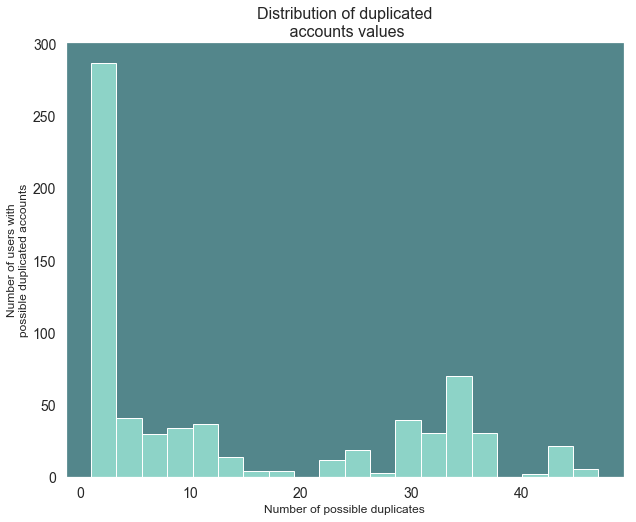

In [121]:
plt.title('Distribution of duplicated\n accounts values')
only_suspicious[only_suspicious['n_duplicates'] > 0]['n_duplicates'].hist(bins = 20)
plt.ylabel('Number of users with\npossible duplicated accounts')
plt.xlabel('Number of possible duplicates')
plt.show()

In [122]:
only_suspicious[only_suspicious['n_duplicates'] > 0].shape[0]

687

In [123]:
100*(only_suspicious[only_suspicious['n_duplicates'] > 0].shape[0] / allcountries['user_id'].nunique())

0.038428062890014075

In [124]:
print('The match between user and his possible duplucated account')

len(set(allcountries[allcountries['user_id'] == '008b39ca99a36bd1eed3df13f733767450ae9230']['track_id'].unique()) & \
set(allcountries[allcountries['user_id'] == 'b0e12af6bf1ee8b10a78f7797e4d5f6a154bf1fa']['track_id'].unique())) / len(set(allcountries[allcountries['user_id'] == '008b39ca99a36bd1eed3df13f733767450ae9230']['track_id'].unique()))

The match between user and his possible duplucated account


1.0

## Graph of users with possible multiple accounts

I want to build a graph of users who potentially have multiple accounts to see how closely they interact.

The vertices of the graph are users, the edges are connections between users in close neighborhood.

The width of edges will be number of common tracks, the size of vertices will be number of tracks that user streamed

In [125]:
connected = only_suspicious[only_suspicious['n_duplicates'] > 0]
connected.head()

,user_id,track_id,possible_duplicate_accounts,n_duplicates
16,00be2da40114d81aec8a515e905d8e8cc624969f,"[45d054cba06f055820ca4ab1b164d78bcdf2115c, 591...","[551d94f179025aa8143327e22feb694849058a8c, 564...",37
20,00e391b23a8d5c0026f6fa378f1fd7c36abd6d58,"[6b2b5684b0cac43de5f9b742e75549a729adbe4d, 190...","[2c16dafa571f65b2c80eee3c243b27eb2034f461, 3b4...",11
28,0176560911f3ab2a0054a9323937fab0e7a400c1,"[3a7fdfcc3614f28c44ed2799feff6238fd8c81c2, f79...","[97b4dd0cde3df449fd8491aa65e844c284f3bf41, 9e7...",34
37,01ff6ab6c189fd9bb0adf6513c6ac64343b65f66,"[2f789ed847980341dd7996e11dc28fc6f1927d75, 5d5...","[71d07546fbc30b529ed3e627e924d0bae5814ddb, 898...",37
40,0217fed781bf92f8b54c9d7a61aed0051385be91,"[d3cbdf573c6f685b2069080ee5bb3d61e33dda74, 183...","[00be2da40114d81aec8a515e905d8e8cc624969f, 9a3...",36


In [126]:
smallcountries = allcountries[allcountries['user_id'].isin(only_suspicious[only_suspicious['n_duplicates'] > 0]['user_id'].unique())]

In [127]:
left = [] 
right = []

for row in connected.iterrows():
    for con in row[1]['possible_duplicate_accounts']:
        pair = (row[1]['user_id'], con) if row[1]['user_id'] < con else (con, row[1]['user_id'])
        left.append(pair[0])
        right.append(pair[1])

In [128]:
len(left) == len(right)

True

In [129]:
connected = pd.DataFrame({'left' : left, 'right' : right}).drop_duplicates(keep = 'first')

In [130]:
connected.shape

(5072, 2)

In [131]:
track_left = pd.merge(connected[['left', 'right']], 
                      smallcountries[['user_id', 'track_id']], how = 'inner', left_on = 'left', right_on = 'user_id')

track_right = pd.merge(connected[['left', 'right']], 
                      smallcountries[['user_id', 'track_id']], how = 'inner', left_on = 'right', right_on = 'user_id')

tracks = pd.merge(track_left, track_right, how = 'inner', on = ['left', 'right', 'track_id'])

tracks = tracks.groupby(['left', 'right'])['track_id'].nunique().reset_index().rename(columns = {'track_id' : 'n_tracks'})
connected = pd.merge(connected, tracks, how = 'left', on = ['left', 'right'])

In [132]:
connected.shape

(5072, 3)

In [133]:
connected['left_tracks'] = connected['left'].map(smallcountries.groupby('user_id')['track_id'].nunique().to_dict())
connected['right_tracks'] = connected['right'].map(smallcountries.groupby('user_id')['track_id'].nunique().to_dict())
connected['similarity'] = connected['n_tracks'] / (connected['left_tracks']  + connected['right_tracks'])

In [134]:
connected = connected[connected['similarity'] > 0.4]

In [135]:
connected.shape

(5067, 6)

In [136]:
vertices = list(set(connected['left'].unique()).union(set(connected['right'].unique())))

s_dict = smallcountries.groupby('user_id')['track_id'].nunique().to_dict()
v_sizes = [s_dict[v] for v in vertices]

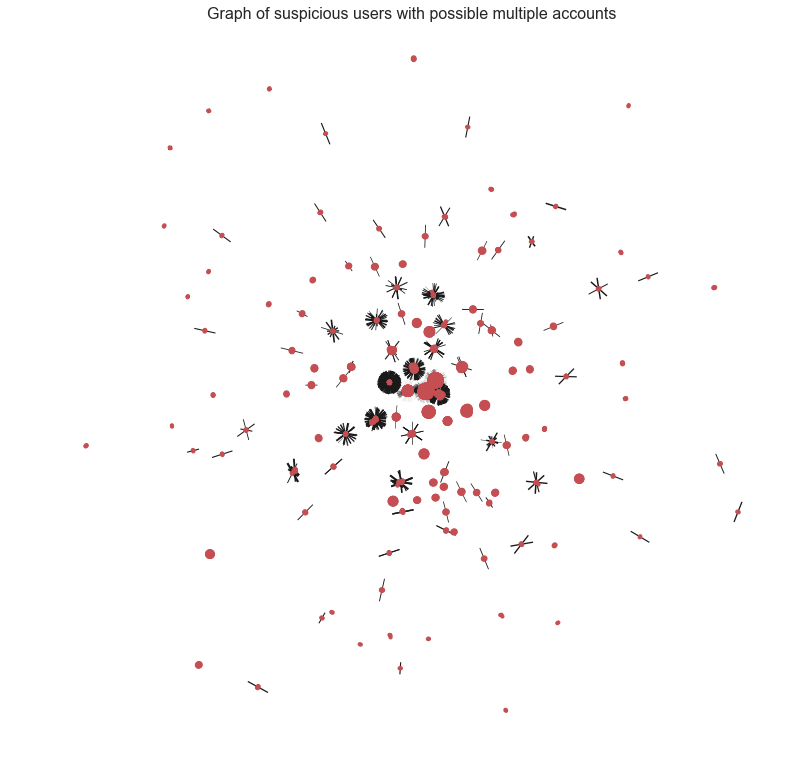

In [137]:
G = nx.Graph(directed = False)

 
for v, s in zip(vertices, v_sizes):

    G.add_node(v, 
        nodesize=s)

for index, row in connected.iterrows():

    G.add_weighted_edges_from([(row['left'], row['right'], row['n_tracks'])])



pos=nx.spring_layout(G, random_state = 0, iterations = 100)


plt.figure(figsize=(10, 10))
nx.draw(G, pos, nodelist=vertices,
        node_size = [v for v in v_sizes], width = [w/10 for w in connected['n_tracks'].values],
        arrows = False,
        cmap=plt.cm.jet)
plt.title('Graph of suspicious users with possible multiple accounts')
plt.show()

A piece of graph for ne user with a lot of similar accounts

In [138]:
connected = connected[(connected['left'] == '449632cc73b1d60f9693d87c3fdbab638fbc12d1') | (connected['right'] == '449632cc73b1d60f9693d87c3fdbab638fbc12d1')]

In [139]:
vertices = list(set(connected['left'].unique()).union(set(connected['right'].unique())))

s_dict = smallcountries.groupby('user_id')['track_id'].nunique().to_dict()
v_sizes = [s_dict[v] for v in vertices]

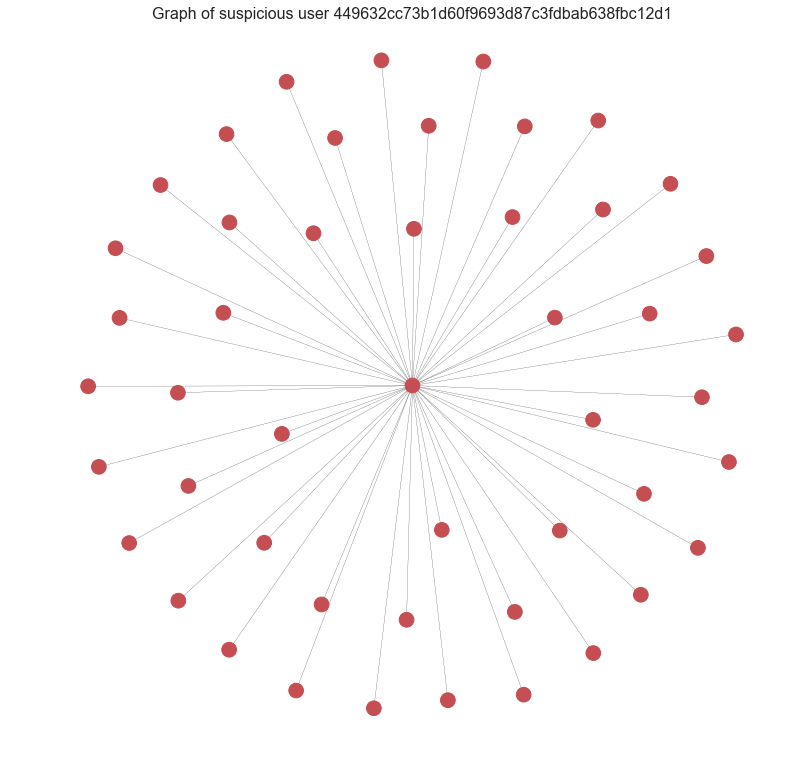

In [140]:
G = nx.Graph(directed = False)

 
for v, s in zip(vertices, v_sizes):

    G.add_node(v, 
        nodesize=s)

for index, row in connected.iterrows():

    G.add_weighted_edges_from([(row['left'], row['right'], row['n_tracks'])])



pos=nx.spring_layout(G, random_state = 0, iterations = 300)


plt.figure(figsize=(10, 10))
nx.draw(G, pos, nodelist=vertices,
        node_size = [v for v in v_sizes], width = [w/1000 for w in connected['n_tracks'].values],
        arrows = False,
        cmap=plt.cm.jet)
plt.title('Graph of suspicious user 449632cc73b1d60f9693d87c3fdbab638fbc12d1')
plt.show()

In [141]:
100*(len(set(connected['left'].unique()).union(connected['right'].unique())) / allcountries['user_id'].nunique())

0.002684930158254258

## Step 2 conclusions:




For now I determine two types of fraudsters:
    
    - Type I: extremely active users (~0.3%)
    - Type II: extremely active users with possible multiple accounts (~0.003%)

<div class="alert alert-block alert-warning">
<ul><b>
    <li style="font-size:20px">Suspicious users tend to use multiple tightly connected accounts</li>
    <li style="font-size:20px">There are about 0.3% of suspicious users and 0.003% users with multiple accounts </li>
    </b>
</ul>
</div>

# Some other info about Type II fraudsters

## By countries

In [142]:
only_suspicious = only_suspicious[only_suspicious['n_duplicates'] > 0]
users['fraudster'] = users['user_id'].isin(only_suspicious['user_id'].unique())*1

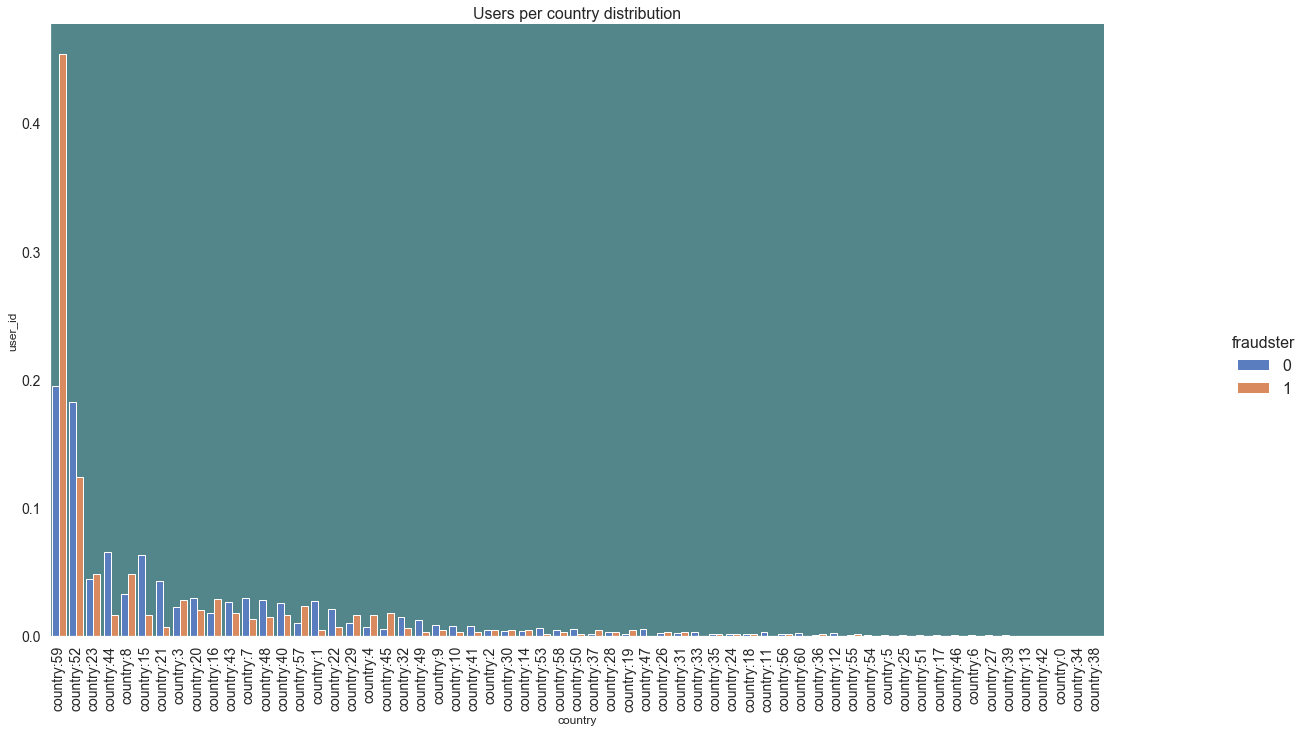

In [143]:
t = users.groupby(['country', 'fraudster'])['user_id'].nunique().reset_index()
t['user_id'] = t['user_id'] / t['fraudster'].map(t.groupby('fraudster')['user_id'].sum().to_dict())
t['sum'] = t['country'].map(t.groupby('country')['user_id'].sum().to_dict())
t.sort_values(by = 'sum', inplace = True, ascending = False)


fig = sns.catplot(x="country", y="user_id", hue="fraudster", data=t, 
                height=6, kind="bar", palette="muted")
fig.fig.set_size_inches(20,10)
ax = plt.gca()
ax.set_title("Users per country distribution")
plt.setp(fig._legend.get_title(), fontsize='16')
plt.xticks(rotation=90) 
plt.show()

## By access type

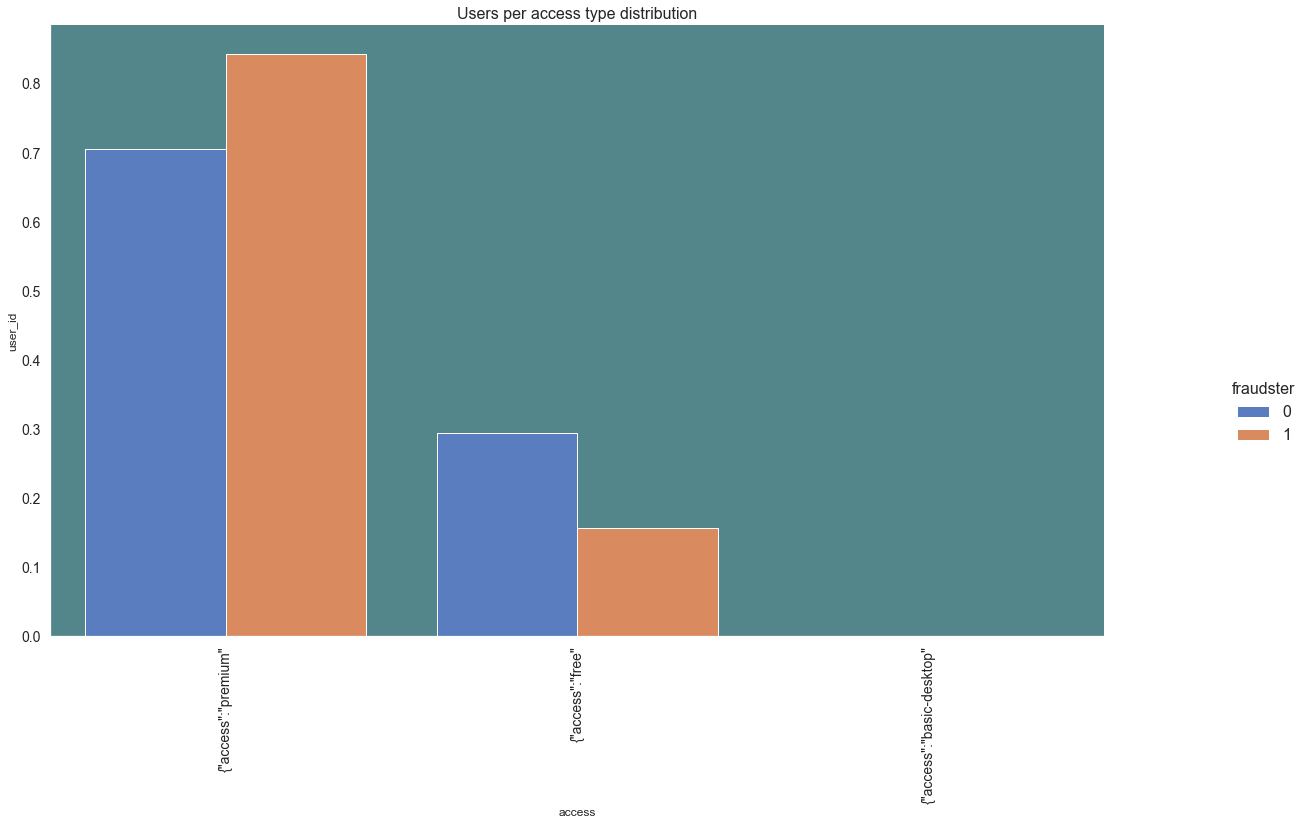

In [144]:
t = users.groupby(['access', 'fraudster'])['user_id'].nunique().reset_index()
t['user_id'] = t['user_id'] / t['fraudster'].map(t.groupby('fraudster')['user_id'].sum().to_dict())
t['sum'] = t['access'].map(t.groupby('access')['user_id'].sum().to_dict())
t.sort_values(by = 'sum', inplace = True, ascending = False)


fig = sns.catplot(x="access", y="user_id", hue="fraudster", data=t, 
                height=6, kind="bar", palette="muted")
fig.fig.set_size_inches(20,10)
ax = plt.gca()
ax.set_title("Users per access type distribution", fontsize = 16)
plt.setp(fig._legend.get_title(), fontsize='16')
plt.xticks(rotation=90) 
plt.show()

## By age

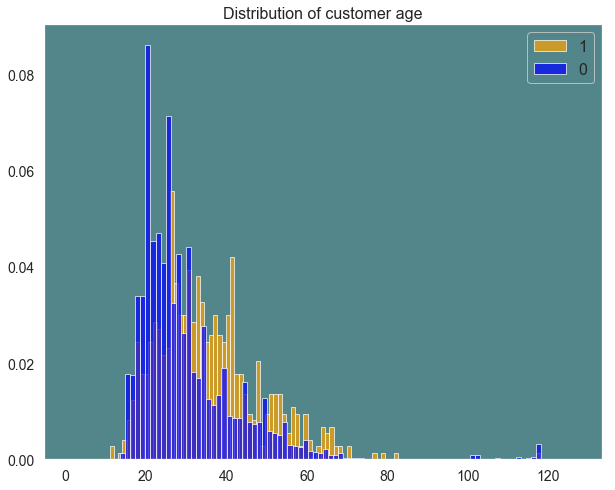

In [145]:
plt.title('Distribution of customer age')
users[users['fraudster'] == 1]['age'].hist(bins = 100, label = '1', normed = True, color = 'orange', alpha = 0.7)
users[users['fraudster'] == 0]['age'].hist(bins = 100, label = '0', normed = True, color = "blue", alpha = 0.7)
plt.legend()
plt.show()

## By OS

In [146]:
allcountries['fraudster'] = allcountries['user_id'].isin(only_suspicious['user_id'].unique())*1

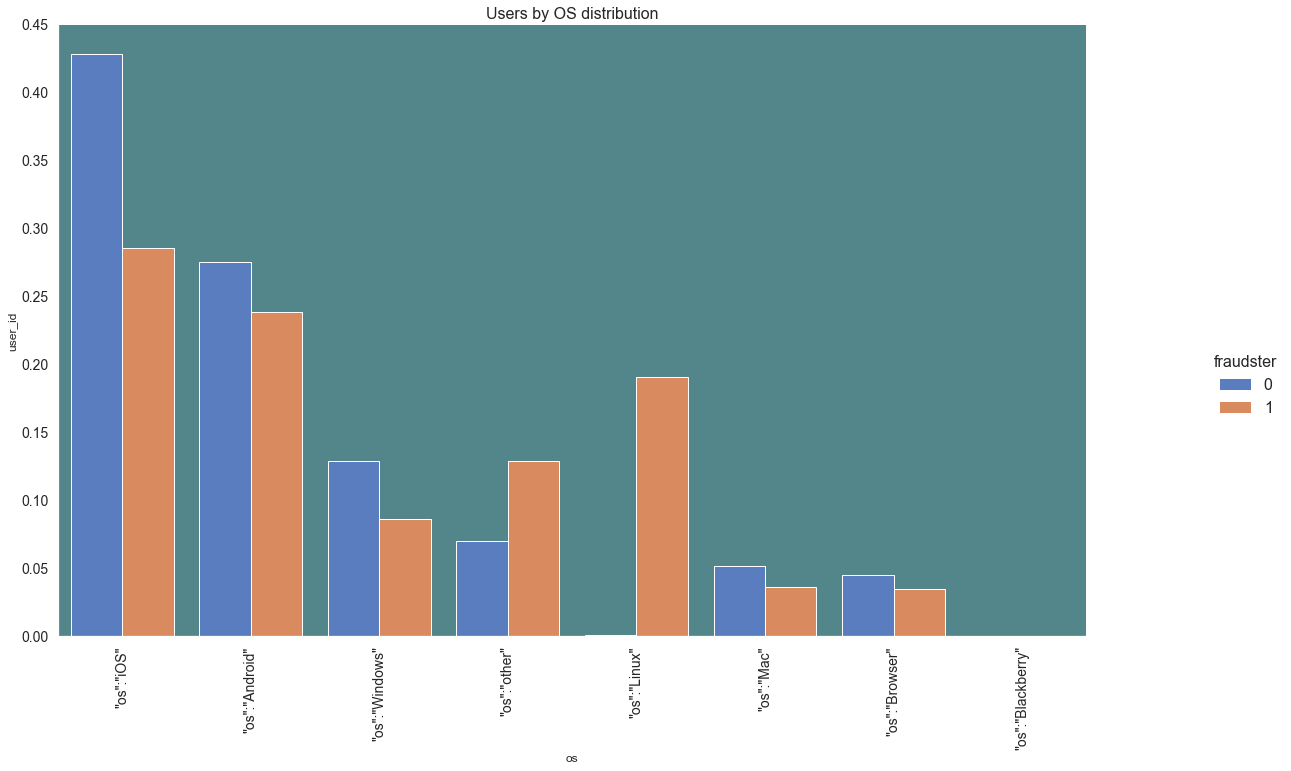

In [147]:
t = allcountries.groupby(['os', 'fraudster'])['user_id'].nunique().reset_index()
t['user_id'] = t['user_id'] / t['fraudster'].map(t.groupby('fraudster')['user_id'].sum().to_dict())
t['sum'] = t['os'].map(t.groupby('os')['user_id'].sum().to_dict())
t.sort_values(by = 'sum', inplace = True, ascending = False)


fig = sns.catplot(x="os", y="user_id", hue="fraudster", data=t, 
                height=6, kind="bar", palette="muted")
fig.fig.set_size_inches(20,10)
ax = plt.gca()
ax.set_title("Users by OS distribution", fontsize = 16)
plt.setp(fig._legend.get_title(), fontsize='16')
plt.xticks(rotation=90) 
plt.show()

## By device type

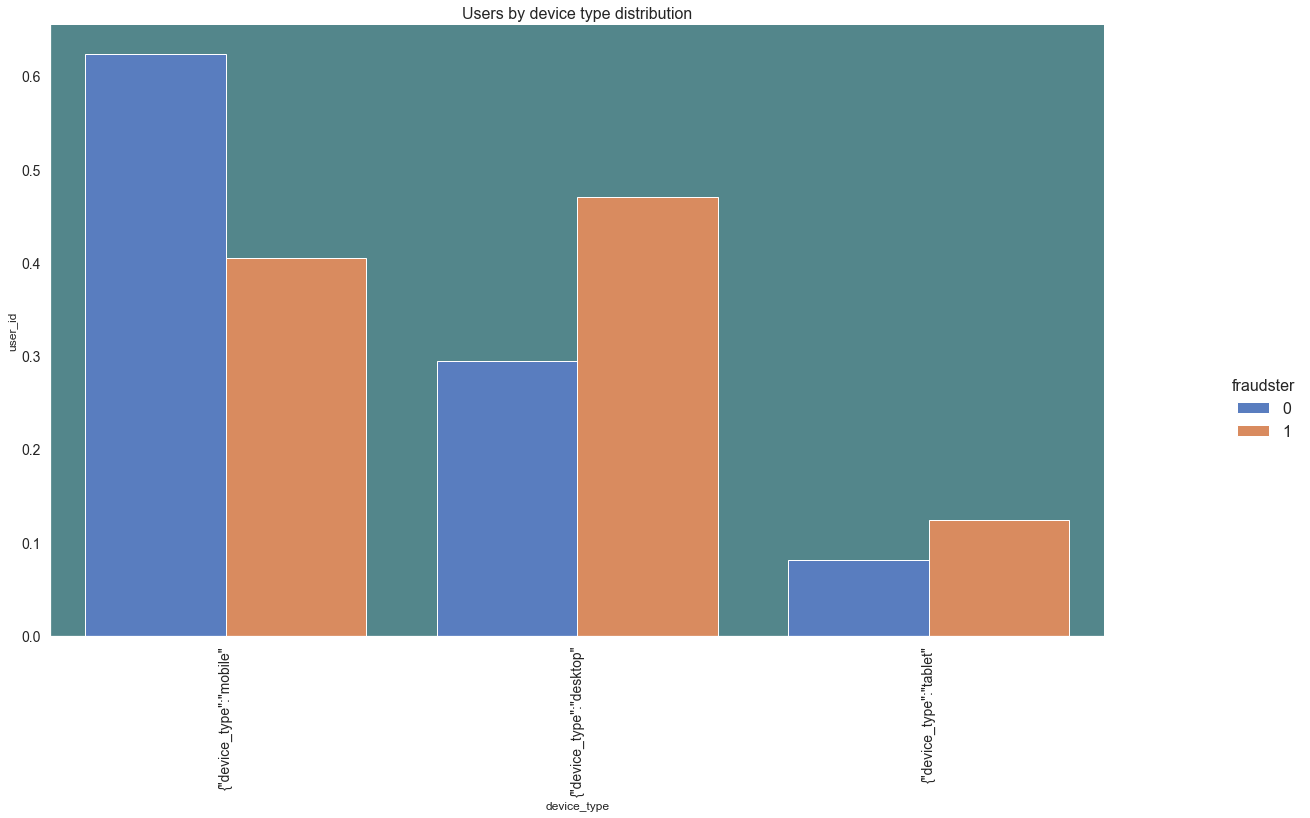

In [148]:
t = allcountries.groupby(['device_type', 'fraudster'])['user_id'].nunique().reset_index()
t['user_id'] = t['user_id'] / t['fraudster'].map(t.groupby('fraudster')['user_id'].sum().to_dict())
t['sum'] = t['device_type'].map(t.groupby('device_type')['user_id'].sum().to_dict())
t.sort_values(by = 'sum', inplace = True, ascending = False)


fig = sns.catplot(x="device_type", y="user_id", hue="fraudster", data=t, 
                height=6, kind="bar", palette="muted")
fig.fig.set_size_inches(20,10)
ax = plt.gca()
ax.set_title("Users by device type distribution", fontsize = 16)
plt.setp(fig._legend.get_title(), fontsize='16')
plt.xticks(rotation=90) 
plt.show()

<div class="alert alert-block alert-warning">
<ul><b>
    <li style="font-size:20px">Suspicious users tend to be from country 59, older and to use Linux system and desktop devices</li>
    </b>
</ul>
</div>

# STEP 4: FRAUD MODEL

Fraud model consists of two parts:
    - detect users with suspicious statistics
    - try to find most similar users among suspicious

Model is expected to find 0.3% of users with extreme activity and 0.003% of users with possible multiple accouts

Model output will look like this

In [149]:
pd.merge(allusers[allusers['outlier'] == 1][['user_id', 'gender', 'age', 'user_track_unique', 
                                             'user_stream_length_mean', 'user_gap_mean',
                                             'user_track_count', 'user_track_mean_share']], 
         only_suspicious[['user_id', 'possible_duplicate_accounts', 'n_duplicates']],
        how = 'left', on = 'user_id'
        ).head()

,user_id,gender,age,user_track_unique,user_stream_length_mean,user_gap_mean,user_track_count,user_track_mean_share,possible_duplicate_accounts,n_duplicates
0,7d486e1321f8f4d0bba841c934fc9ab4629d26ce,0,28,4.19,0.04,-0.28,2.05,0.01,NaN,nan
1,524a149eeda0eefa1bf4165f8c33a0213ef1681a,1,51,6.87,-0.50,-0.37,2.12,-0.18,NaN,nan
2,3829699e1a7369115fbd920e257d3ce4f6b4dd9d,0,53,5.65,0.12,-0.24,2.64,0.04,NaN,nan
3,ed136c02c74c5fac95ab4ea3661d749b8f2170fc,0,41,2.25,-1.42,-0.22,3.09,0.02,NaN,nan
4,e52172b0ad5ccf6232306c3dc7992ec151cd5543,1,27,55.51,-0.85,-0.36,136.42,0.11,"[97b4dd0cde3df449fd8491aa65e844c284f3bf41, 9e7...",34.00
